In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 2
DIS_N_CLASSES = 1
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 3e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [13]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [14]:
perceptual_ext = PerceptualLoss()

In [15]:
sobel_filter = Sobel().to(device)

In [16]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)
    
    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    edge_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)
        edge_x = sobel_filter(x)
        
        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()
        
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        y_cls = discriminator(torch.cat((y, edge_y), dim=1))
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(torch.cat((y_pr.detach(), edge_y_pr.detach()), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _dis = nn.BCELoss()(y_cls.float(), torch.zeros(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # main loss
        # Perceptual loss
        perceptual_loss = perceptual_ext(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())
        
        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = discriminator(torch.cat((y_pr, edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = _gen + air_loss + bone_loss + perceptual_loss + _mae 
        _loss.backward()    
        gen_optimizer.step()

        dis_l += _dis.item()
        gen_l += _gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        mae_l += _mae.item()
        perceptual_l += perceptual_loss.item()
        
    return  perceptual_l/(index+1), mae_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [17]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    cont_ = []
    edge_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)
        edge_x = sobel_filter(x)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        y_cls = discriminator(torch.cat((y, edge_y), dim=1))
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(torch.cat((y_pr, edge_y_pr), dim=1))
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.zeros(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.ones(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]
        
        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(acc_)/len(acc_)

In [18]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [19]:
from codes.activation import Activation
import torchvision.models as models

In [20]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = models.resnet18()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=512, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Generator

In [21]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [22]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[256, 128, 64, 32, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [23]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [24]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [25]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [26]:
len(trainset), len(testset)

(1344, 191)

In [27]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f0a353cc6a0>,)

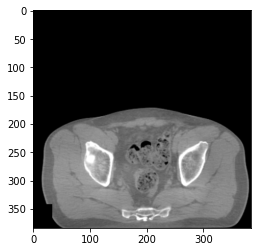

In [28]:
plt.imshow(x.squeeze(), 'gray'),

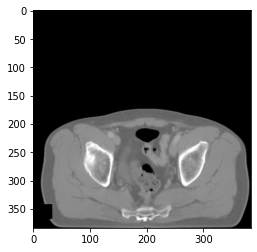

In [29]:
plt.imshow(y.squeeze(), 'gray')

In [30]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [31]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [33]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = Generator(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 attention_type=DECODER_ATT)

In [34]:
discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [35]:
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
replace_relu_to_leakyReLU(discriminator)

In [36]:
model

Generator(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slo

In [37]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [38]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_perceptual, loss_mae, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_cont_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_cont_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        wandb.log({
            "loss mae": loss_mae,
            "loss perceptual": loss_perceptual,
            "loss mask": loss_air,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "loss bone": loss_bone,
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test + score_cont_test >  max_score:
            max_score = score_bone_test +  score_air_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [02:55,  1.05s/it]
168it [00:39,  4.29it/s]
24it [00:05,  4.08it/s]
168it [02:51,  1.02s/it]
168it [00:43,  3.87it/s]
24it [00:06,  3.89it/s]
168it [02:49,  1.01s/it]
168it [00:40,  4.12it/s]
24it [00:06,  3.75it/s]
168it [02:49,  1.01s/it]
168it [00:40,  4.12it/s]
24it [00:06,  3.72it/s]
168it [02:49,  1.01s/it]
168it [00:42,  3.93it/s]
24it [00:06,  3.88it/s]
168it [02:51,  1.02s/it]
168it [00:38,  4.33it/s]
24it [00:06,  3.59it/s]
168it [02:51,  1.02s/it]
168it [00:39,  4.22it/s]
24it [00:05,  4.17it/s]
168it [02:51,  1.02s/it]
168it [00:42,  3.95it/s]
24it [00:06,  3.88it/s]
168it [02:49,  1.01s/it]
168it [00:40,  4.17it/s]
24it [00:06,  3.80it/s]
168it [02:49,  1.01s/it]
168it [00:40,  4.13it/s]
24it [00:05,  4.17it/s]
168it [02:49,  1.01s/it]
168it [00:41,  4.02it/s]
24it [00:06,  3.67it/s]
168it [02:52,  1.03s/it]
168it [00:38,  4.31it/s]
24it [00:06,  3.82it/s]
168it [02:51,  1.02s/it]
168it [00:39,  4.20it/s]
24it [00:08,  3.00it/s]
168it [02:51,  1.02s/it]
168it [00:41,

In [39]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [40]:
model = model = Generator(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [41]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8303676843643188
psnr score = 20.639638900756836
snr score = 10.702576637268066
mae error = 0.03250214830040932
air dice score = 0.9805516868230609
bone dice score = 2.9036004644917653e-11
contour dice score = 0.013381995260715485


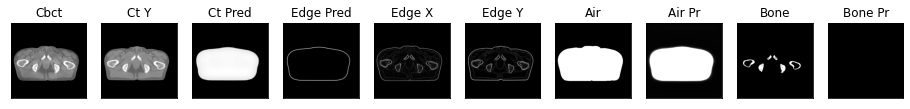

1it [00:00,  1.67it/s]

ssim score = 0.8318498134613037
psnr score = 20.633668899536133
snr score = 10.744141578674316
mae error = 0.03251924365758896
air dice score = 0.9810830007102818
bone dice score = 2.8868360276302878e-11
contour dice score = 0.04143814742565155


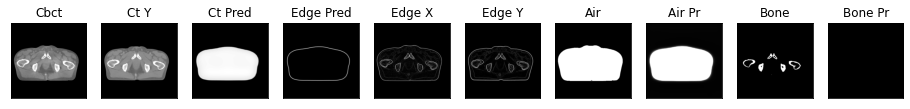

2it [00:01,  1.61it/s]

ssim score = 0.8286338448524475
psnr score = 20.370296478271484
snr score = 10.643669128417969
mae error = 0.03369973972439766
air dice score = 0.9832074473923319
bone dice score = 2.3963575364870272e-11
contour dice score = 0.09494826197624207


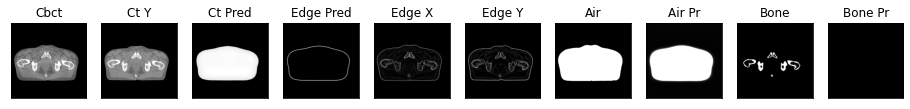

3it [00:01,  1.80it/s]

ssim score = 0.8246466517448425
psnr score = 20.19656753540039
snr score = 10.559188842773438
mae error = 0.034926850348711014
air dice score = 0.9843459856638137
bone dice score = 2.1473051320131565e-11
contour dice score = 0.15497253835201263


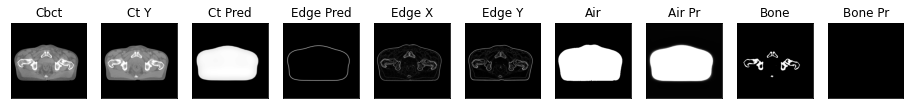

4it [00:02,  1.93it/s]

ssim score = 0.8220669031143188
psnr score = 20.194223403930664
snr score = 10.597146987915039
mae error = 0.03575341776013374
air dice score = 0.9847246536287854
bone dice score = 1.9286403085452526e-11
contour dice score = 0.19682151079177856


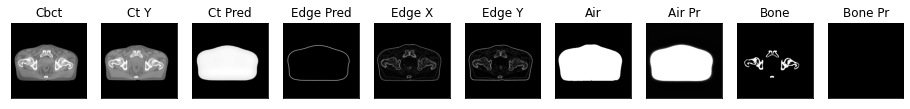

5it [00:02,  2.05it/s]

ssim score = 0.8208054304122925
psnr score = 19.942670822143555
snr score = 10.482129096984863
mae error = 0.03751906752586365
air dice score = 0.9858620724255367
bone dice score = 1.6329196603260463e-11
contour dice score = 0.2023298591375351


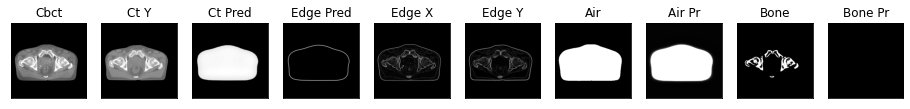

6it [00:02,  2.15it/s]

ssim score = 0.8221457004547119
psnr score = 19.989948272705078
snr score = 10.505352020263672
mae error = 0.03707326576113701
air dice score = 0.9858012578616495
bone dice score = 1.563966218305224e-11
contour dice score = 0.17311233282089233


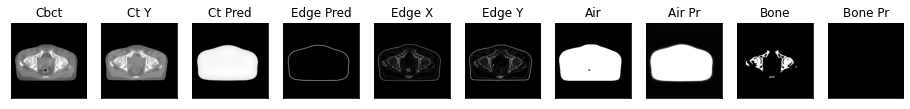

7it [00:03,  2.23it/s]

ssim score = 0.8324851989746094
psnr score = 20.423126220703125
snr score = 10.752991676330566
mae error = 0.034222811460494995
air dice score = 0.9874960767042417
bone dice score = 1.7394329448297195e-11
contour dice score = 0.2404439002275467


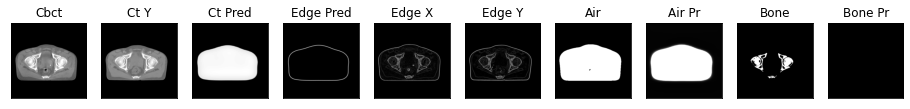

8it [00:03,  2.25it/s]

ssim score = 0.8376963138580322
psnr score = 20.553834915161133
snr score = 10.789144515991211
mae error = 0.03318899869918823
air dice score = 0.9865508345824167
bone dice score = 1.898974553704919e-11
contour dice score = 0.2414860725402832


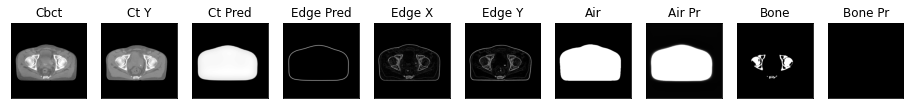

9it [00:04,  2.32it/s]

ssim score = 0.8459799289703369
psnr score = 20.703516006469727
snr score = 10.923542976379395
mae error = 0.032179683446884155
air dice score = 0.9876181600319658
bone dice score = 1.9920318724702783e-11
contour dice score = 0.2582246959209442


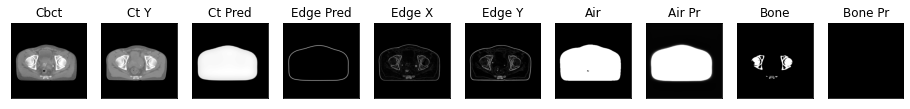

10it [00:04,  2.35it/s]

ssim score = 0.853768527507782
psnr score = 20.68252944946289
snr score = 10.93482780456543
mae error = 0.03179861605167389
air dice score = 0.9876337276949025
bone dice score = 2.105706464474506e-11
contour dice score = 0.2803970277309418


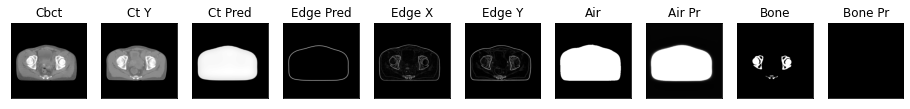

11it [00:05,  2.38it/s]

ssim score = 0.8621912598609924
psnr score = 20.623336791992188
snr score = 10.89934253692627
mae error = 0.03165227547287941
air dice score = 0.985016866372814
bone dice score = 2.107481559491939e-11
contour dice score = 0.3513345718383789


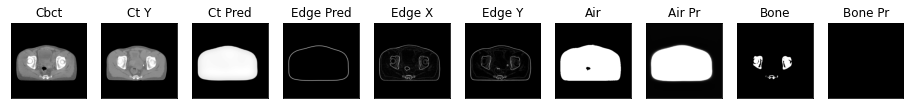

12it [00:05,  2.04it/s]

ssim score = 0.868476927280426
psnr score = 20.718597412109375
snr score = 10.962682723999023
mae error = 0.030579695478081703
air dice score = 0.9826488396086009
bone dice score = 2.2583559168415004e-11
contour dice score = 0.28944098949432373


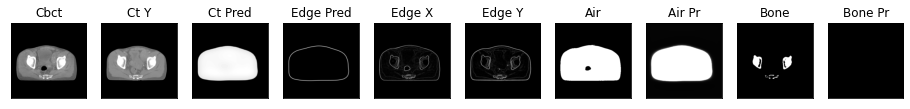

13it [00:06,  2.09it/s]

ssim score = 0.8665308356285095
psnr score = 21.473785400390625
snr score = 11.575913429260254
mae error = 0.028466075658798218
air dice score = 0.9821349847801174
bone dice score = 2.4467824809775684e-11
contour dice score = 0.24265165627002716


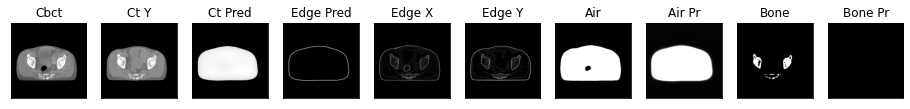

14it [00:06,  2.20it/s]

ssim score = 0.8655965924263
psnr score = 21.76323127746582
snr score = 11.779698371887207
mae error = 0.02753775380551815
air dice score = 0.9813783997887706
bone dice score = 2.5920165888389833e-11
contour dice score = 0.2726704180240631


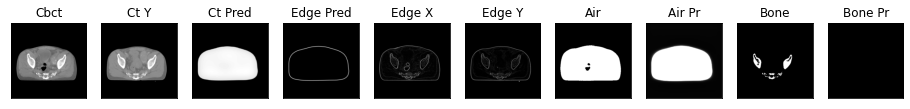

15it [00:06,  2.28it/s]

ssim score = 0.8621273040771484
psnr score = 21.467655181884766
snr score = 11.50760555267334
mae error = 0.02886059507727623
air dice score = 0.9811280520311535
bone dice score = 2.4770869456904362e-11
contour dice score = 0.3147208094596863


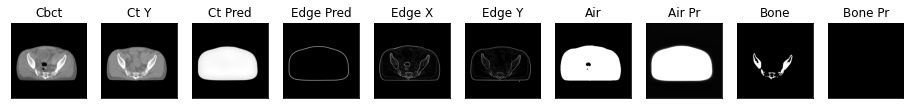

16it [00:07,  2.34it/s]

ssim score = 0.8552277684211731
psnr score = 21.068988800048828
snr score = 11.10639476776123
mae error = 0.030085278674960136
air dice score = 0.9795174262734804
bone dice score = 2.3441162681119523e-11
contour dice score = 0.29936304688453674


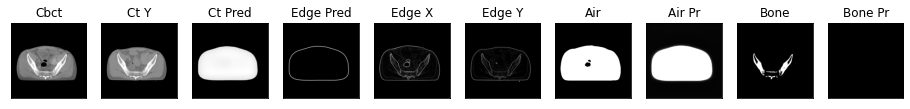

17it [00:07,  2.38it/s]

ssim score = 0.8514196872711182
psnr score = 21.138620376586914
snr score = 11.074267387390137
mae error = 0.030247444286942482
air dice score = 0.977015348339181
bone dice score = 2.364625206848791e-11
contour dice score = 0.2622333765029907


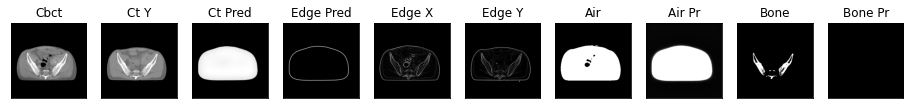

18it [00:08,  2.40it/s]

ssim score = 0.8480095863342285
psnr score = 21.04367446899414
snr score = 10.928640365600586
mae error = 0.030671531334519386
air dice score = 0.9772642889903496
bone dice score = 2.3331777880930195e-11
contour dice score = 0.2866365313529968


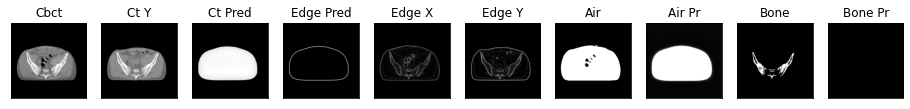

19it [00:08,  2.42it/s]

ssim score = 0.8449633121490479
psnr score = 20.84186363220215
snr score = 10.714517593383789
mae error = 0.031055904924869537
air dice score = 0.9806507000088265
bone dice score = 2.4113817216684018e-11
contour dice score = 0.26170623302459717


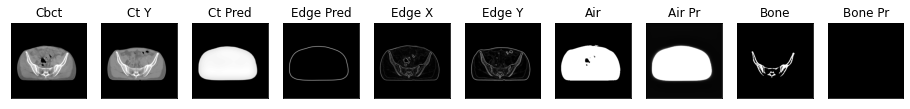

20it [00:08,  2.45it/s]

ssim score = 0.8414018154144287
psnr score = 20.73538589477539
snr score = 10.543194770812988
mae error = 0.031261470168828964
air dice score = 0.9808495512308042
bone dice score = 2.61780104705189e-11
contour dice score = 0.2503242492675781


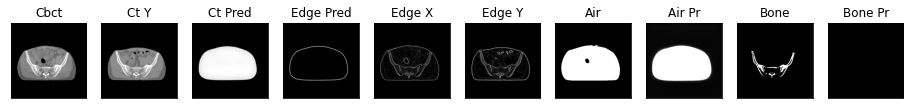

21it [00:09,  2.44it/s]

ssim score = 0.8348782658576965
psnr score = 20.488643646240234
snr score = 10.237022399902344
mae error = 0.03197239711880684
air dice score = 0.9826606505913127
bone dice score = 2.585315408412996e-11
contour dice score = 0.12418300658464432


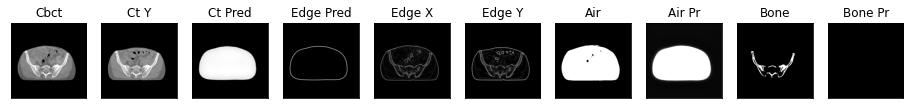

22it [00:09,  2.07it/s]

ssim score = 0.8286803960800171
psnr score = 20.13509750366211
snr score = 9.850049018859863
mae error = 0.03330707922577858
air dice score = 0.9838810588222094
bone dice score = 2.427184465960505e-11
contour dice score = 0.0762656182050705


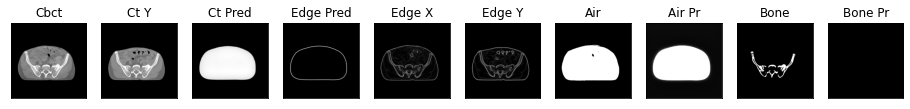

23it [00:10,  2.12it/s]

ssim score = 0.8266308903694153
psnr score = 19.908056259155273
snr score = 9.574442863464355
mae error = 0.03454824164509773
air dice score = 0.9837331127653896
bone dice score = 2.3337222869933788e-11
contour dice score = 0.04417670518159866


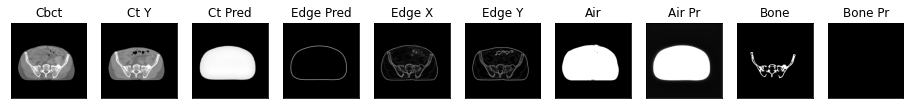

24it [00:10,  2.23it/s]

ssim score = 0.8236333131790161
psnr score = 19.81583595275879
snr score = 9.385222434997559
mae error = 0.03502032160758972
air dice score = 0.9819379466052395
bone dice score = 2.2416498542425095e-11
contour dice score = 0.046070460230112076


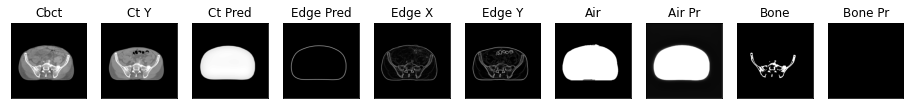

25it [00:11,  2.24it/s]

ssim score = 0.825901210308075
psnr score = 19.8449649810791
snr score = 9.331616401672363
mae error = 0.03474254533648491
air dice score = 0.9803479992414419
bone dice score = 2.220248667801504e-11
contour dice score = 0.1439342051744461


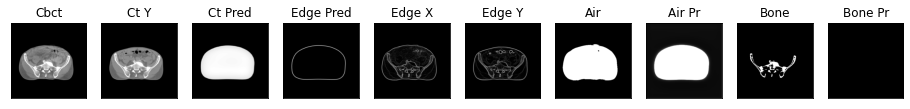

26it [00:11,  2.32it/s]

ssim score = 0.8316461443901062
psnr score = 19.937917709350586
snr score = 9.333383560180664
mae error = 0.03440361097455025
air dice score = 0.9808320968890085
bone dice score = 2.181025081740872e-11
contour dice score = 0.12885154783725739


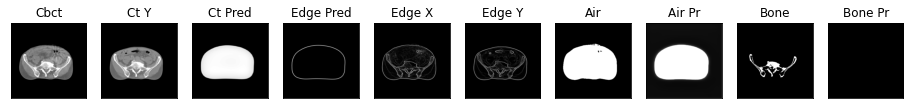

27it [00:12,  2.32it/s]

ssim score = 0.8329662084579468
psnr score = 19.964200973510742
snr score = 9.318561553955078
mae error = 0.03418784216046333
air dice score = 0.9792665812435423
bone dice score = 2.0768431982953927e-11
contour dice score = 0.18426647782325745


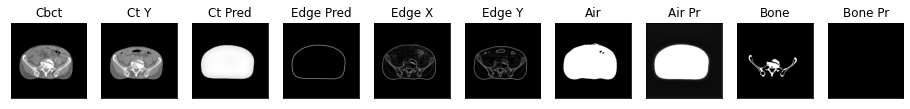

28it [00:12,  2.36it/s]

ssim score = 0.7932982444763184
psnr score = 18.958629608154297
snr score = 10.330787658691406
mae error = 0.05341562256217003
air dice score = 0.9820426211386218
bone dice score = 6.36132315481162e-11
contour dice score = 0.12851405143737793


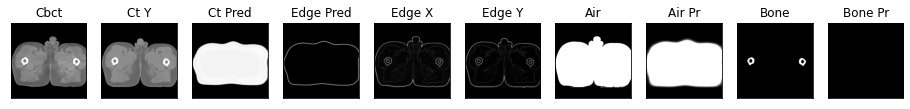

29it [00:12,  2.40it/s]

ssim score = 0.7917037606239319
psnr score = 18.94321632385254
snr score = 10.354629516601562
mae error = 0.05411500483751297
air dice score = 0.9821623101968888
bone dice score = 5.934718100537998e-11
contour dice score = 0.12889084219932556


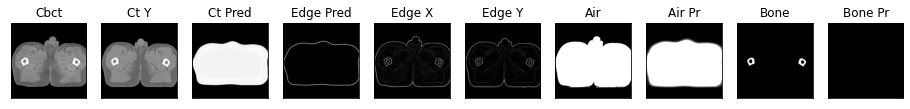

30it [00:13,  2.42it/s]

ssim score = 0.7886375784873962
psnr score = 18.942943572998047
snr score = 10.441804885864258
mae error = 0.054868023842573166
air dice score = 0.9829348652530305
bone dice score = 4.67508181371318e-11
contour dice score = 0.1413588672876358


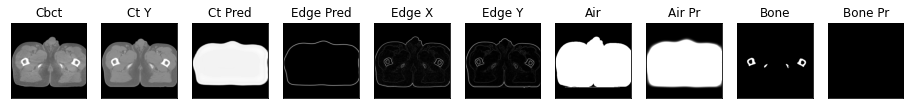

31it [00:13,  2.39it/s]

ssim score = 0.7823070287704468
psnr score = 18.91380500793457
snr score = 10.575226783752441
mae error = 0.0559636689722538
air dice score = 0.9847071362705623
bone dice score = 3.1867431484006776e-11
contour dice score = 0.16135084629058838


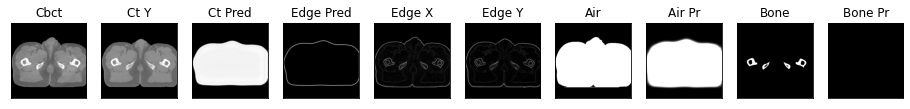

32it [00:14,  2.03it/s]

ssim score = 0.7717146873474121
psnr score = 18.78913116455078
snr score = 10.578695297241211
mae error = 0.056884754449129105
air dice score = 0.9867349673883987
bone dice score = 2.7555800495245087e-11
contour dice score = 0.15965989232063293


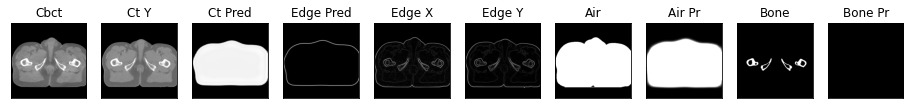

33it [00:14,  2.14it/s]

ssim score = 0.76809161901474
psnr score = 18.703760147094727
snr score = 10.596562385559082
mae error = 0.05762526020407677
air dice score = 0.9878381261705579
bone dice score = 2.3986567521612218e-11
contour dice score = 0.15530303120613098


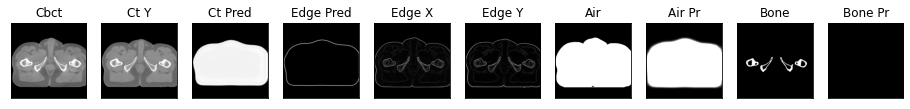

34it [00:15,  2.19it/s]

ssim score = 0.7639786601066589
psnr score = 18.55951690673828
snr score = 10.51941967010498
mae error = 0.05916217342019081
air dice score = 0.9882191845503764
bone dice score = 2.1953896816202988e-11
contour dice score = 0.1410984843969345


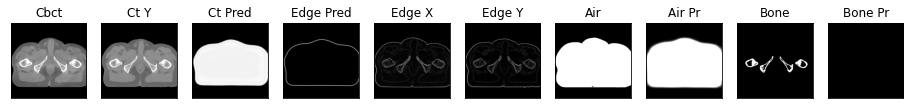

35it [00:15,  2.26it/s]

ssim score = 0.7587302327156067
psnr score = 18.507484436035156
snr score = 10.457496643066406
mae error = 0.05949520319700241
air dice score = 0.9878826380555823
bone dice score = 2.0733982997704042e-11
contour dice score = 0.13962264358997345


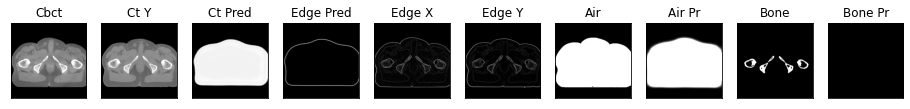

36it [00:16,  2.32it/s]

ssim score = 0.7577244639396667
psnr score = 18.42436981201172
snr score = 10.3607177734375
mae error = 0.05955597385764122
air dice score = 0.9889961242361752
bone dice score = 2.052966536603306e-11
contour dice score = 0.1352885514497757


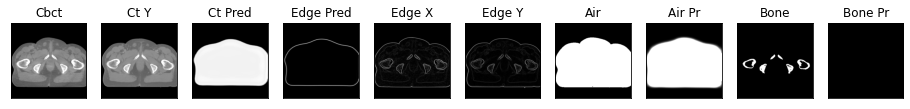

37it [00:16,  2.31it/s]

ssim score = 0.7591475248336792
psnr score = 18.39459991455078
snr score = 10.342949867248535
mae error = 0.06000346690416336
air dice score = 0.9890670553935924
bone dice score = 2.170609941346416e-11
contour dice score = 0.13061997294425964


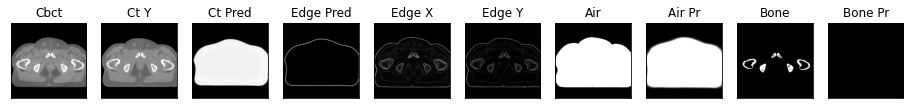

38it [00:16,  2.35it/s]

ssim score = 0.7548649907112122
psnr score = 18.340547561645508
snr score = 10.327982902526855
mae error = 0.0601130910217762
air dice score = 0.9894984418180811
bone dice score = 2.2311468094102822e-11
contour dice score = 0.13194115459918976


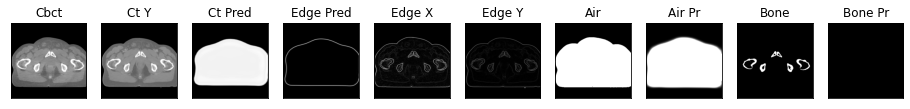

39it [00:17,  2.40it/s]

ssim score = 0.7467517256736755
psnr score = 18.025033950805664
snr score = 10.153757095336914
mae error = 0.06211168318986893
air dice score = 0.9901131191077722
bone dice score = 1.901140684374503e-11
contour dice score = 0.13029006123542786


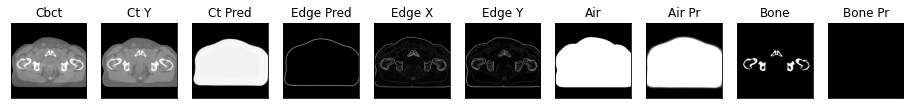

40it [00:17,  2.42it/s]

ssim score = 0.7365987300872803
psnr score = 17.805744171142578
snr score = 10.029155731201172
mae error = 0.06432145088911057
air dice score = 0.9898293499269376
bone dice score = 1.5703517587693097e-11
contour dice score = 0.1307251900434494


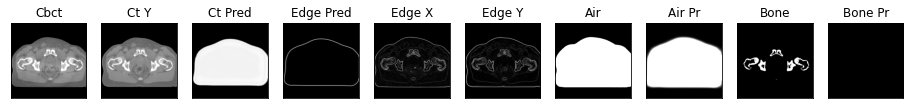

41it [00:18,  2.37it/s]

ssim score = 0.7255867719650269
psnr score = 17.933345794677734
snr score = 10.122710227966309
mae error = 0.06479361653327942
air dice score = 0.989975529890186
bone dice score = 1.520450053192634e-11
contour dice score = 0.12547892332077026


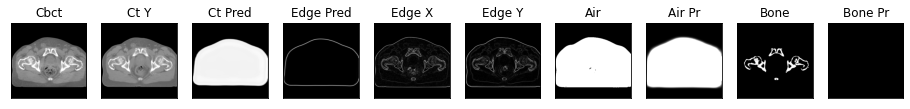

42it [00:18,  2.01it/s]

ssim score = 0.7230892777442932
psnr score = 17.66602325439453
snr score = 9.927574157714844
mae error = 0.06733576208353043
air dice score = 0.9895981227908697
bone dice score = 1.2884937507887064e-11
contour dice score = 0.1259615421295166


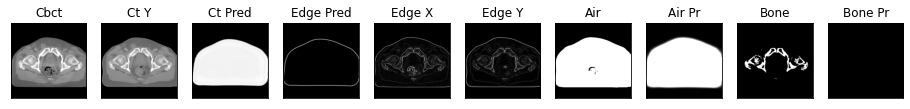

43it [00:19,  2.08it/s]

ssim score = 0.7320870757102966
psnr score = 18.058116912841797
snr score = 10.183572769165039
mae error = 0.06345144659280777
air dice score = 0.9884334161646207
bone dice score = 1.669727834335119e-11
contour dice score = 0.10875841975212097


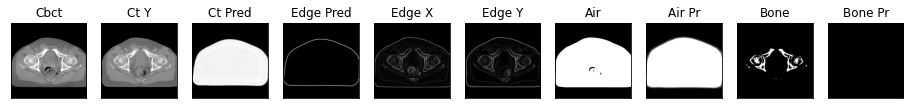

44it [00:19,  2.19it/s]

ssim score = 0.7412217259407043
psnr score = 18.465572357177734
snr score = 10.41246509552002
mae error = 0.05965696647763252
air dice score = 0.9868076079702625
bone dice score = 1.8821757951838475e-11
contour dice score = 0.15057915449142456


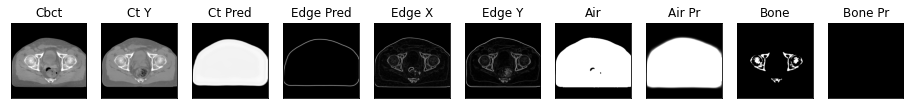

45it [00:20,  2.20it/s]

ssim score = 0.7497925758361816
psnr score = 18.550504684448242
snr score = 10.406808853149414
mae error = 0.059475820511579514
air dice score = 0.987600788389185
bone dice score = 2.1294718909256925e-11
contour dice score = 0.1666666716337204


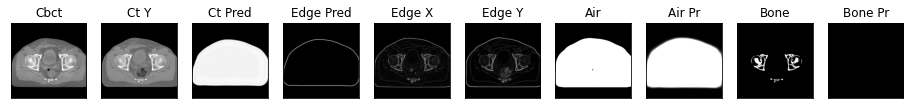

46it [00:20,  2.27it/s]

ssim score = 0.7579689621925354
psnr score = 18.41248893737793
snr score = 10.284482955932617
mae error = 0.06071343645453453
air dice score = 0.9872628271246688
bone dice score = 1.983339944427145e-11
contour dice score = 0.17281553149223328


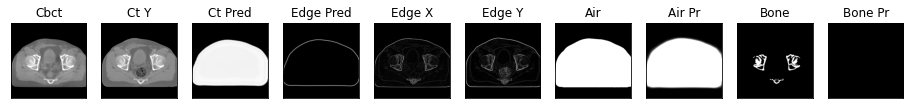

47it [00:20,  2.30it/s]

ssim score = 0.7602189183235168
psnr score = 18.30064582824707
snr score = 10.182680130004883
mae error = 0.06103726103901863
air dice score = 0.9869319243027728
bone dice score = 1.7966223499497554e-11
contour dice score = 0.1690962165594101


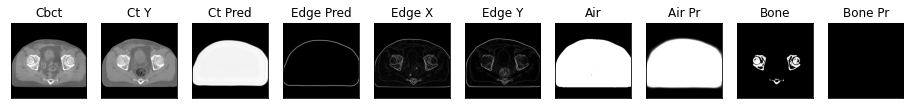

48it [00:21,  2.34it/s]

ssim score = 0.7652094960212708
psnr score = 18.08811378479004
snr score = 10.031733512878418
mae error = 0.060924530029296875
air dice score = 0.9865015105740262
bone dice score = 1.7488632388641332e-11
contour dice score = 0.17572815716266632


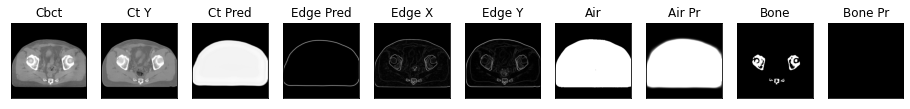

49it [00:21,  2.33it/s]

ssim score = 0.7687017321586609
psnr score = 17.945716857910156
snr score = 9.959418296813965
mae error = 0.061243850737810135
air dice score = 0.9872684413687867
bone dice score = 1.7155601303531385e-11
contour dice score = 0.16973811388015747


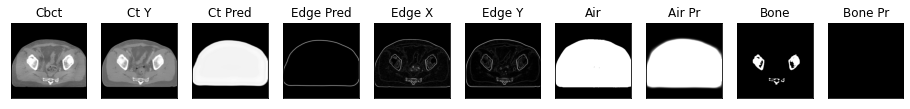

50it [00:22,  2.37it/s]

ssim score = 0.7600476741790771
psnr score = 18.20316505432129
snr score = 10.097760200500488
mae error = 0.06012348458170891
air dice score = 0.9875381855210278
bone dice score = 1.8978933383583622e-11
contour dice score = 0.16197866201400757


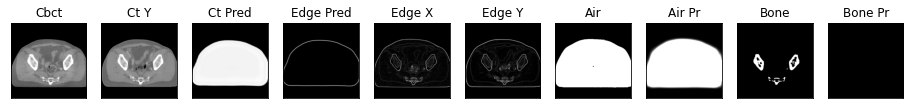

51it [00:22,  2.34it/s]

ssim score = 0.7487556338310242
psnr score = 17.73102569580078
snr score = 9.70724868774414
mae error = 0.06452221423387527
air dice score = 0.9886585558156811
bone dice score = 1.6531658125036674e-11
contour dice score = 0.14048780500888824


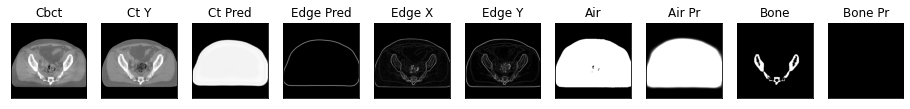

52it [00:23,  2.01it/s]

ssim score = 0.7390731573104858
psnr score = 17.526891708374023
snr score = 9.583264350891113
mae error = 0.06622614711523056
air dice score = 0.9878844699833734
bone dice score = 1.3825521913261087e-11
contour dice score = 0.13215859234333038


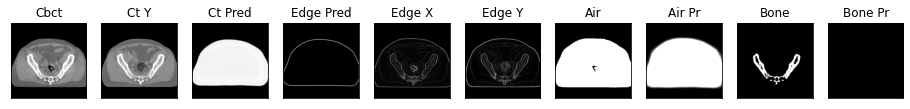

53it [00:23,  2.12it/s]

ssim score = 0.7291907072067261
psnr score = 17.541481018066406
snr score = 9.619406700134277
mae error = 0.06658724695444107
air dice score = 0.9872503803153676
bone dice score = 1.3865779256601972e-11
contour dice score = 0.12463199347257614


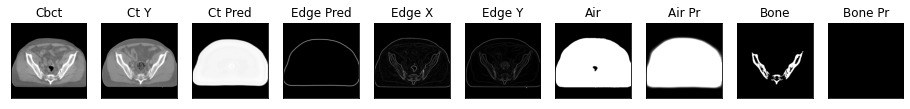

54it [00:24,  2.21it/s]

ssim score = 0.7289646863937378
psnr score = 17.639081954956055
snr score = 9.729548454284668
mae error = 0.06631328910589218
air dice score = 0.9904550499445118
bone dice score = 1.4076576576378426e-11
contour dice score = 0.09686888754367828


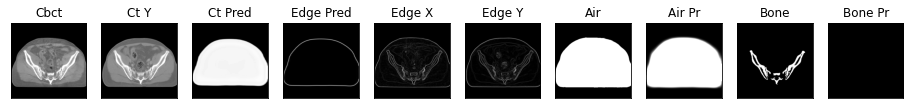

55it [00:24,  2.27it/s]

ssim score = 0.8342908024787903
psnr score = 20.436294555664062
snr score = 10.31650161743164
mae error = 0.03456198796629906
air dice score = 0.9809064888953472
bone dice score = 5.464480874018334e-11
contour dice score = 0.038288287818431854


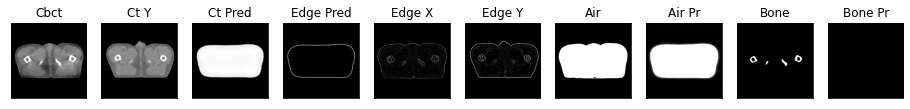

56it [00:24,  2.28it/s]

ssim score = 0.8263759613037109
psnr score = 19.98174285888672
snr score = 10.074931144714355
mae error = 0.03692715987563133
air dice score = 0.9812381724790653
bone dice score = 4.361098996757039e-11
contour dice score = 0.029164329171180725


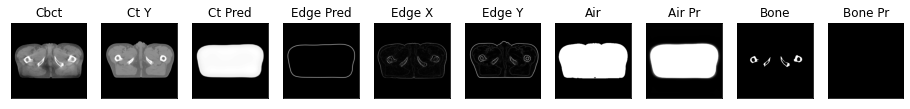

57it [00:25,  2.34it/s]

ssim score = 0.8201618790626526
psnr score = 19.860069274902344
snr score = 10.08439826965332
mae error = 0.03784668445587158
air dice score = 0.9815336070423458
bone dice score = 4.0933278753952794e-11
contour dice score = 0.02903405949473381


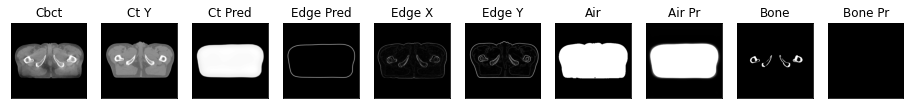

58it [00:25,  2.38it/s]

ssim score = 0.8151229023933411
psnr score = 19.83097267150879
snr score = 10.125703811645508
mae error = 0.038544606417417526
air dice score = 0.9807699168718285
bone dice score = 3.9651070577333427e-11
contour dice score = 0.031215161085128784


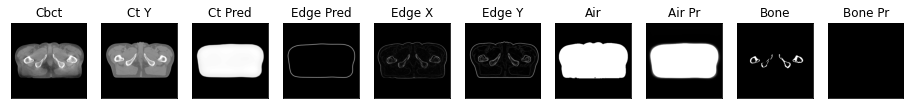

59it [00:26,  2.41it/s]

ssim score = 0.8113052248954773
psnr score = 19.786226272583008
snr score = 10.128521919250488
mae error = 0.03905119746923447
air dice score = 0.9800374907827933
bone dice score = 3.8197097019167415e-11
contour dice score = 0.031093835830688477


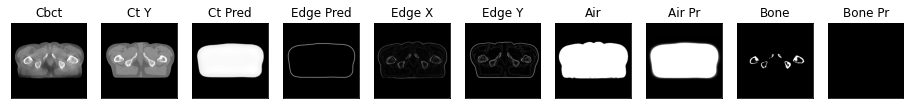

60it [00:26,  2.36it/s]

ssim score = 0.809945821762085
psnr score = 19.745319366455078
snr score = 10.093231201171875
mae error = 0.03922916576266289
air dice score = 0.9793044818150605
bone dice score = 3.716090672474318e-11
contour dice score = 0.07683982700109482


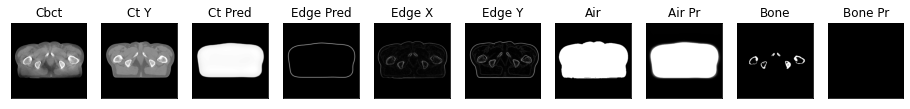

61it [00:27,  2.39it/s]

ssim score = 0.8060520887374878
psnr score = 19.734209060668945
snr score = 10.075620651245117
mae error = 0.03919520601630211
air dice score = 0.9782829666687483
bone dice score = 3.775009437381087e-11
contour dice score = 0.0803474485874176


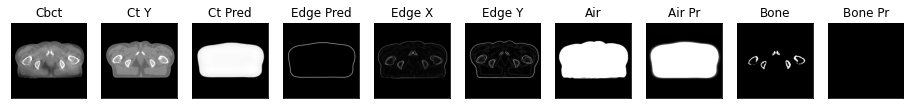

62it [00:27,  1.99it/s]

ssim score = 0.8050771951675415
psnr score = 19.71799659729004
snr score = 10.073516845703125
mae error = 0.03893875330686569
air dice score = 0.9787863577523764
bone dice score = 3.6968576708429996e-11
contour dice score = 0.08346883207559586


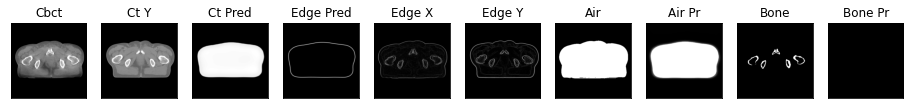

63it [00:28,  2.10it/s]

ssim score = 0.8017004132270813
psnr score = 19.61743927001953
snr score = 10.030965805053711
mae error = 0.03909607231616974
air dice score = 0.9806842636918787
bone dice score = 3.2733224221514463e-11
contour dice score = 0.04468664899468422


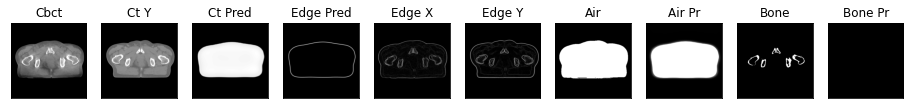

64it [00:28,  2.20it/s]

ssim score = 0.7963285446166992
psnr score = 19.364547729492188
snr score = 9.87663459777832
mae error = 0.04078507423400879
air dice score = 0.9821316175956517
bone dice score = 3.072196620489333e-11
contour dice score = 0.05056481808423996


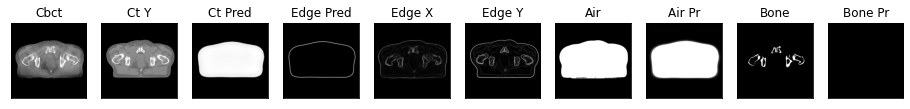

65it [00:28,  2.21it/s]

ssim score = 0.7911615967750549
psnr score = 19.360889434814453
snr score = 9.908804893493652
mae error = 0.04130816459655762
air dice score = 0.9840108046878543
bone dice score = 2.928257686590681e-11
contour dice score = 0.03829321637749672


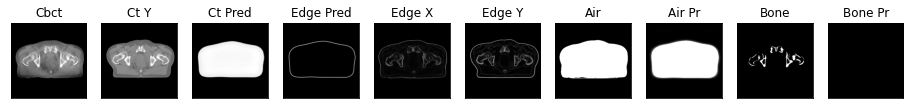

66it [00:29,  2.28it/s]

ssim score = 0.7839852571487427
psnr score = 19.29128074645996
snr score = 9.871901512145996
mae error = 0.04267771169543266
air dice score = 0.9845082074280624
bone dice score = 2.594706798064486e-11
contour dice score = 0.040283069014549255


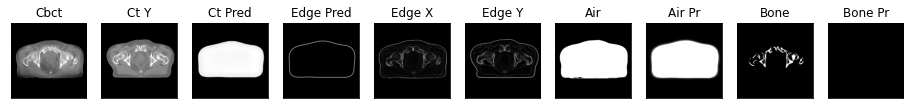

67it [00:29,  2.31it/s]

ssim score = 0.7793949842453003
psnr score = 19.081838607788086
snr score = 9.779275894165039
mae error = 0.04491408169269562
air dice score = 0.9857879227767132
bone dice score = 2.5980774226396966e-11
contour dice score = 0.058855000883340836


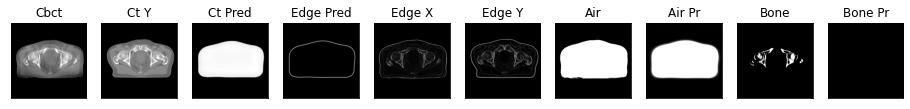

68it [00:30,  2.35it/s]

ssim score = 0.7810155153274536
psnr score = 19.15118980407715
snr score = 9.832642555236816
mae error = 0.044504065066576004
air dice score = 0.9870283223644338
bone dice score = 2.884338044335612e-11
contour dice score = 0.07726269215345383


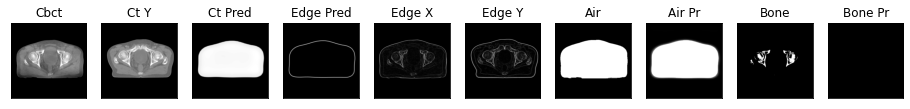

69it [00:30,  2.39it/s]

ssim score = 0.7929103970527649
psnr score = 19.6580753326416
snr score = 10.140363693237305
mae error = 0.040735647082328796
air dice score = 0.9876883833519979
bone dice score = 3.108486167139929e-11
contour dice score = 0.05013623833656311


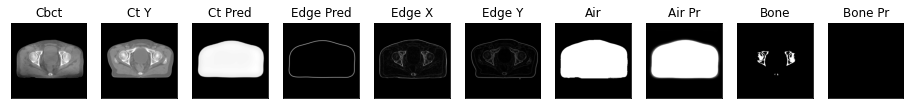

70it [00:31,  2.41it/s]

ssim score = 0.8061222434043884
psnr score = 20.079113006591797
snr score = 10.391008377075195
mae error = 0.03832472115755081
air dice score = 0.9879282275104888
bone dice score = 2.8546959747971826e-11
contour dice score = 0.045826513320207596


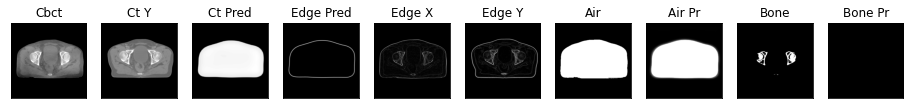

71it [00:31,  2.43it/s]

ssim score = 0.8110397458076477
psnr score = 20.098899841308594
snr score = 10.424965858459473
mae error = 0.038506872951984406
air dice score = 0.9877433184662832
bone dice score = 2.639915522633582e-11
contour dice score = 0.02705627679824829


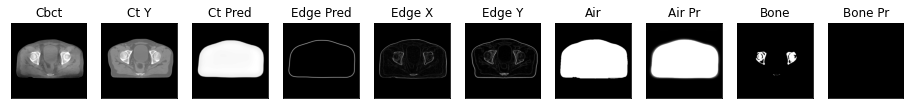

72it [00:32,  2.00it/s]

ssim score = 0.8133068084716797
psnr score = 19.908119201660156
snr score = 10.316010475158691
mae error = 0.03916080668568611
air dice score = 0.9875739951331588
bone dice score = 2.6759432699310692e-11
contour dice score = 0.019812878221273422


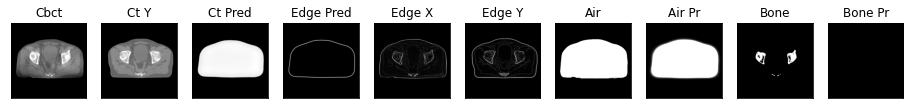

73it [00:32,  2.06it/s]

ssim score = 0.815415620803833
psnr score = 19.70539093017578
snr score = 10.205458641052246
mae error = 0.03925080597400665
air dice score = 0.9880565164266026
bone dice score = 3.0321406912361387e-11
contour dice score = 0.017887087538838387


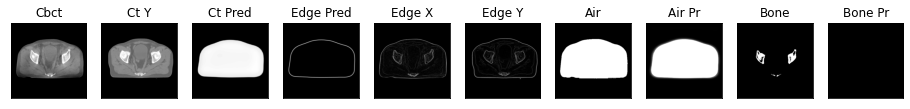

74it [00:32,  2.15it/s]

ssim score = 0.8175678849220276
psnr score = 20.272727966308594
snr score = 10.709365844726562
mae error = 0.03726493567228317
air dice score = 0.9884419787332508
bone dice score = 3.331112591494633e-11
contour dice score = 0.024986419826745987


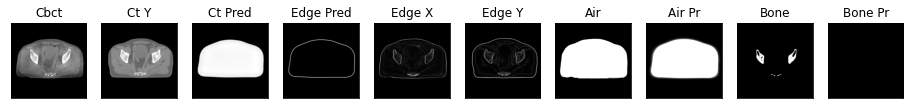

75it [00:33,  2.21it/s]

ssim score = 0.8177334070205688
psnr score = 20.571815490722656
snr score = 10.97205924987793
mae error = 0.035939253866672516
air dice score = 0.9873448028183575
bone dice score = 3.593244699834953e-11
contour dice score = 0.020518358796834946


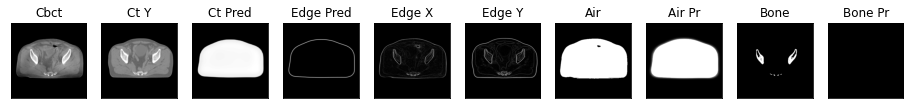

76it [00:33,  2.23it/s]

ssim score = 0.8076775074005127
psnr score = 20.52799415588379
snr score = 10.965986251831055
mae error = 0.036812279373407364
air dice score = 0.986707041675232
bone dice score = 3.291639236231348e-11
contour dice score = 0.06233207881450653


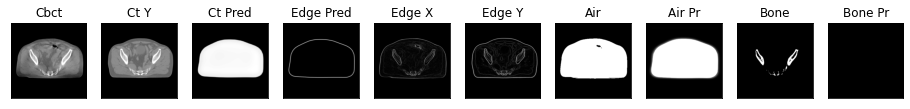

77it [00:34,  2.29it/s]

ssim score = 0.7979030013084412
psnr score = 20.157299041748047
snr score = 10.72579288482666
mae error = 0.03881971165537834
air dice score = 0.9867815009503049
bone dice score = 2.8481913983808548e-11
contour dice score = 0.08770979940891266


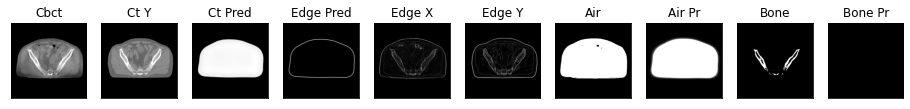

78it [00:34,  2.32it/s]

ssim score = 0.7916563749313354
psnr score = 20.042701721191406
snr score = 10.62894344329834
mae error = 0.04034922644495964
air dice score = 0.9865075201871348
bone dice score = 3.067484662482593e-11
contour dice score = 0.08174386620521545


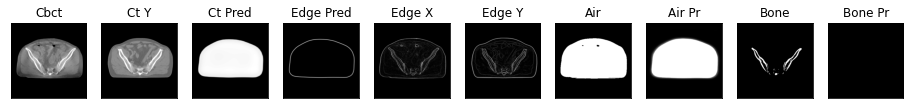

79it [00:35,  2.36it/s]

ssim score = 0.7893357872962952
psnr score = 20.123579025268555
snr score = 10.698554992675781
mae error = 0.04025513678789139
air dice score = 0.9876067341929792
bone dice score = 3.379520108030432e-11
contour dice score = 0.08747949451208115


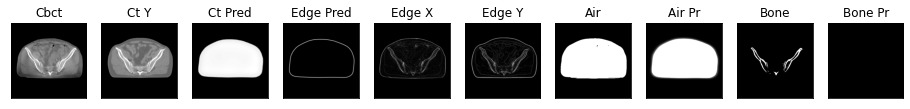

80it [00:35,  2.37it/s]

ssim score = 0.7873659133911133
psnr score = 20.096914291381836
snr score = 10.671150207519531
mae error = 0.04017309844493866
air dice score = 0.987357160223692
bone dice score = 3.257328990121911e-11
contour dice score = 0.06174200773239136


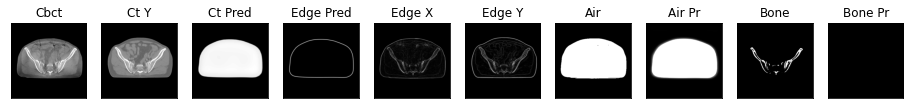

81it [00:35,  2.41it/s]

ssim score = 0.8046660423278809
psnr score = 20.147836685180664
snr score = 10.58197021484375
mae error = 0.03879956528544426
air dice score = 0.9828083220247936
bone dice score = 7.745933384372894e-11
contour dice score = 0.009756097570061684


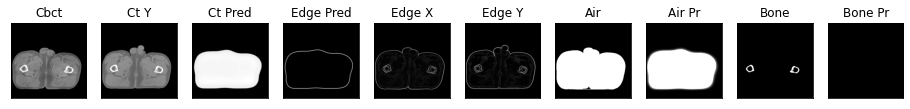

82it [00:36,  1.99it/s]

ssim score = 0.8044100999832153
psnr score = 20.32808494567871
snr score = 10.82661247253418
mae error = 0.03808816149830818
air dice score = 0.984124202426389
bone dice score = 7.102272726768303e-11
contour dice score = 0.02356722019612789


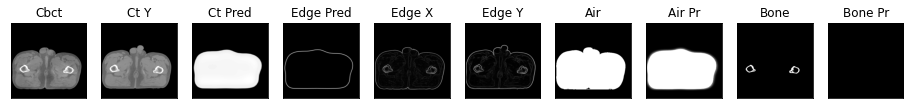

83it [00:37,  2.11it/s]

ssim score = 0.806435763835907
psnr score = 20.6014347076416
snr score = 11.239173889160156
mae error = 0.03744751960039139
air dice score = 0.9837836987637361
bone dice score = 4.5372050814638294e-11
contour dice score = 0.024185068905353546


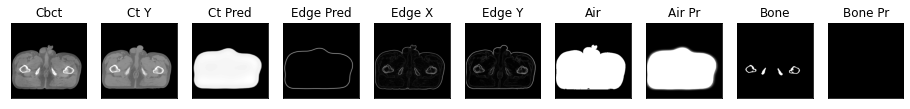

84it [00:37,  2.20it/s]

ssim score = 0.8066734075546265
psnr score = 20.692302703857422
snr score = 11.451532363891602
mae error = 0.03731405735015869
air dice score = 0.9835637432753788
bone dice score = 4.3668122268835455e-11
contour dice score = 0.040296923369169235


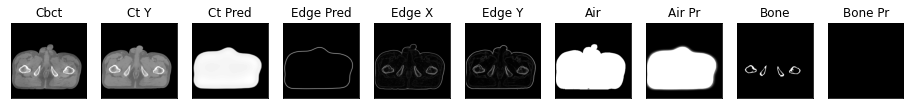

85it [00:37,  2.27it/s]

ssim score = 0.8031735420227051
psnr score = 20.8572940826416
snr score = 11.64069652557373
mae error = 0.03695809096097946
air dice score = 0.9840588978490555
bone dice score = 4.504504504301599e-11
contour dice score = 0.035087719559669495


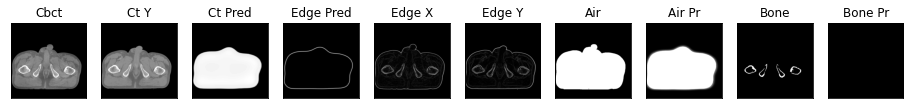

86it [00:38,  2.31it/s]

ssim score = 0.801725447177887
psnr score = 20.908855438232422
snr score = 11.687864303588867
mae error = 0.037023741751909256
air dice score = 0.9848808391913705
bone dice score = 4.1101520754578645e-11
contour dice score = 0.03840000182390213


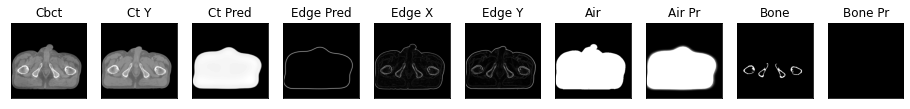

87it [00:38,  2.35it/s]

ssim score = 0.8027012944221497
psnr score = 20.835189819335938
snr score = 11.620450973510742
mae error = 0.037211690098047256
air dice score = 0.9837955020431206
bone dice score = 3.980891719586748e-11
contour dice score = 0.025641025975346565


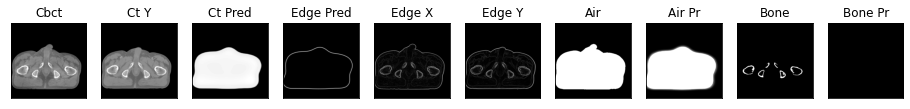

88it [00:39,  2.35it/s]

ssim score = 0.800714373588562
psnr score = 20.620342254638672
snr score = 11.384047508239746
mae error = 0.03759576752781868
air dice score = 0.9836039950608921
bone dice score = 3.958828186699967e-11
contour dice score = 0.0566541962325573


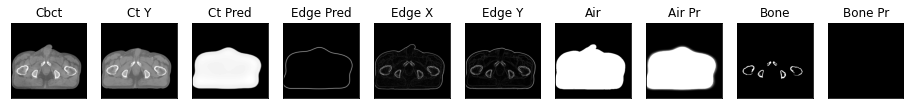

89it [00:39,  2.39it/s]

ssim score = 0.802383542060852
psnr score = 20.44062042236328
snr score = 11.221235275268555
mae error = 0.03848516196012497
air dice score = 0.9829591348604634
bone dice score = 3.700962250048077e-11
contour dice score = 0.07931403815746307


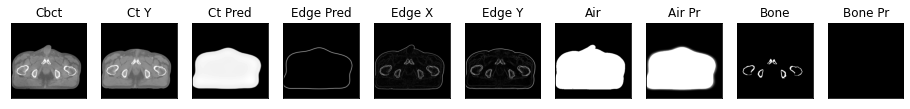

90it [00:39,  2.40it/s]

ssim score = 0.8001658320426941
psnr score = 20.443695068359375
snr score = 11.2929048538208
mae error = 0.03884999081492424
air dice score = 0.9841899722852229
bone dice score = 3.36134453770214e-11
contour dice score = 0.10333692282438278


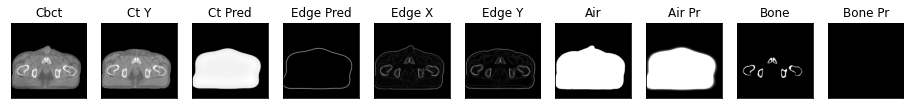

91it [00:40,  2.46it/s]

ssim score = 0.7959346771240234
psnr score = 20.46035385131836
snr score = 11.39091968536377
mae error = 0.038998689502477646
air dice score = 0.9841229679296729
bone dice score = 3.063725490102214e-11
contour dice score = 0.12979988753795624


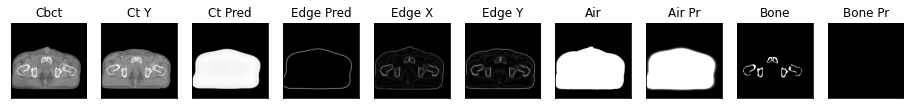

92it [00:40,  2.16it/s]

ssim score = 0.7916134595870972
psnr score = 20.532445907592773
snr score = 11.513715744018555
mae error = 0.03926192969083786
air dice score = 0.9862017039825748
bone dice score = 2.908667830049195e-11
contour dice score = 0.13196322321891785


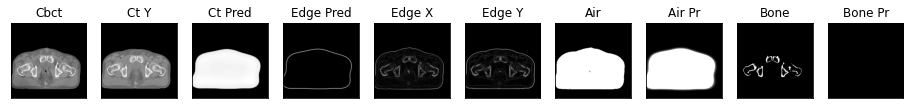

93it [00:41,  2.22it/s]

ssim score = 0.7863930463790894
psnr score = 20.26809310913086
snr score = 11.365632057189941
mae error = 0.040785182267427444
air dice score = 0.9878092363896376
bone dice score = 2.642007925953976e-11
contour dice score = 0.14850948750972748


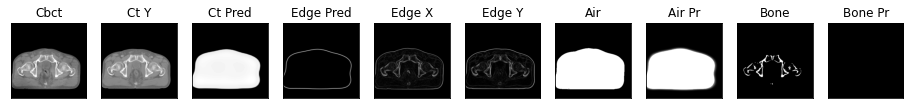

94it [00:41,  2.33it/s]

ssim score = 0.7863214612007141
psnr score = 20.4261474609375
snr score = 11.485450744628906
mae error = 0.0404440201818943
air dice score = 0.9864266369284799
bone dice score = 2.8677946658196788e-11
contour dice score = 0.16603364050388336


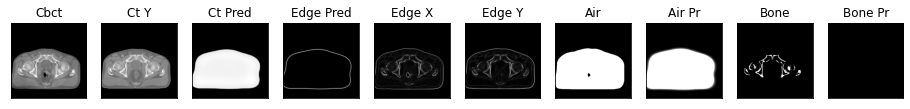

95it [00:42,  2.42it/s]

ssim score = 0.7866891622543335
psnr score = 20.356792449951172
snr score = 11.320426940917969
mae error = 0.040509626269340515
air dice score = 0.9836755679809893
bone dice score = 2.635046113237548e-11
contour dice score = 0.09046321362257004


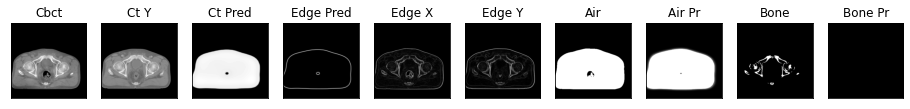

96it [00:42,  2.47it/s]

ssim score = 0.7909620404243469
psnr score = 20.08102035522461
snr score = 10.884893417358398
mae error = 0.04018348455429077
air dice score = 0.9826457158642347
bone dice score = 3.317850033068419e-11
contour dice score = 0.07205240428447723


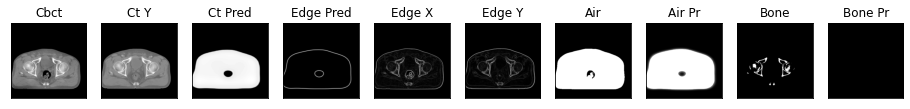

97it [00:42,  2.52it/s]

ssim score = 0.7934942245483398
psnr score = 19.98650360107422
snr score = 10.673954010009766
mae error = 0.040366239845752716
air dice score = 0.9844441343304539
bone dice score = 3.424657534129292e-11
contour dice score = 0.14129243791103363


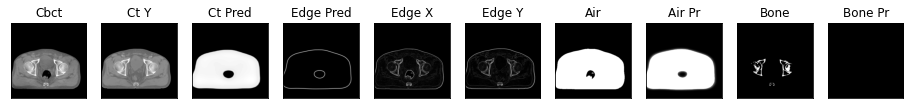

98it [00:43,  2.55it/s]

ssim score = 0.7984429001808167
psnr score = 20.021162033081055
snr score = 10.663516998291016
mae error = 0.04067810997366905
air dice score = 0.985877384016378
bone dice score = 3.183699458669733e-11
contour dice score = 0.11758241802453995


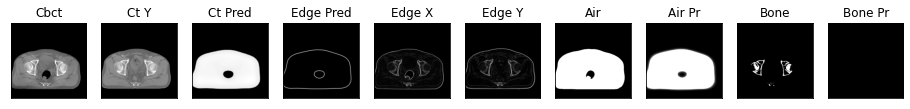

99it [00:43,  2.59it/s]

ssim score = 0.7998363971710205
psnr score = 19.82066535949707
snr score = 10.469693183898926
mae error = 0.041676003485918045
air dice score = 0.9861812054482343
bone dice score = 3.183699458669733e-11
contour dice score = 0.07158590108156204


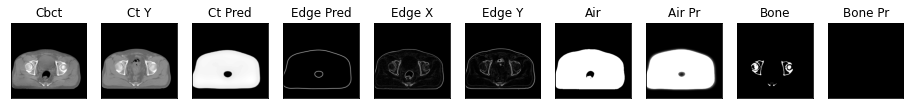

100it [00:44,  2.47it/s]

ssim score = 0.8006787896156311
psnr score = 19.616453170776367
snr score = 10.295586585998535
mae error = 0.042331188917160034
air dice score = 0.9855414917875793
bone dice score = 3.0012004801020045e-11
contour dice score = 0.07611693441867828


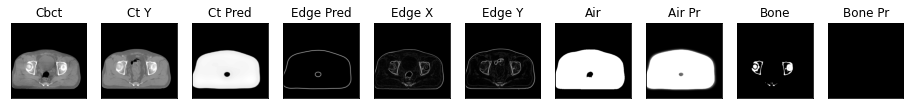

101it [00:44,  2.50it/s]

ssim score = 0.805549681186676
psnr score = 19.961793899536133
snr score = 10.598339080810547
mae error = 0.040372416377067566
air dice score = 0.9875328570604672
bone dice score = 3.3333333332222224e-11
contour dice score = 0.10485651344060898


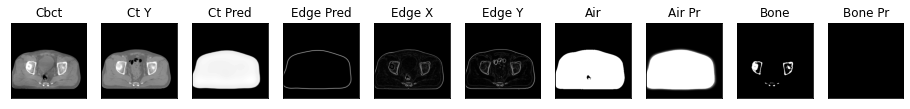

102it [00:46,  1.10it/s]

ssim score = 0.79744553565979
psnr score = 19.938642501831055
snr score = 10.48498249053955
mae error = 0.04034242033958435
air dice score = 0.9877738410100406
bone dice score = 3.736920777139876e-11
contour dice score = 0.06843267381191254


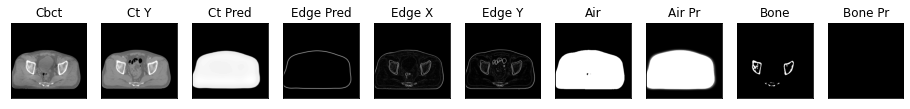

103it [00:47,  1.09it/s]

ssim score = 0.7979541420936584
psnr score = 20.000999450683594
snr score = 10.48161506652832
mae error = 0.03977607563138008
air dice score = 0.9863703082407328
bone dice score = 3.907776475032912e-11
contour dice score = 0.0764966756105423


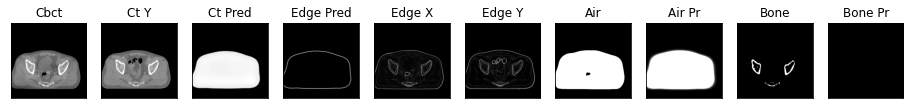

104it [00:48,  1.21it/s]

ssim score = 0.7967077493667603
psnr score = 19.941146850585938
snr score = 10.421459197998047
mae error = 0.03988270461559296
air dice score = 0.9859884869254132
bone dice score = 3.415300546331445e-11
contour dice score = 0.11679644137620926


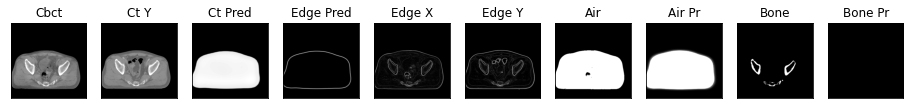

105it [00:48,  1.34it/s]

ssim score = 0.7897468209266663
psnr score = 19.72959327697754
snr score = 10.286073684692383
mae error = 0.0415000393986702
air dice score = 0.9837464860720813
bone dice score = 2.778549597033105e-11
contour dice score = 0.1384701281785965


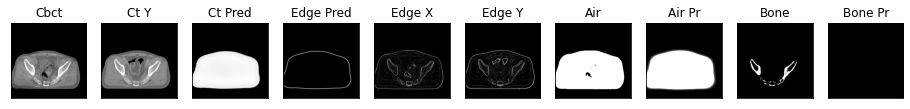

106it [00:49,  1.51it/s]

ssim score = 0.785200834274292
psnr score = 19.42110252380371
snr score = 10.013165473937988
mae error = 0.043702080845832825
air dice score = 0.9830246250376182
bone dice score = 2.5906735750624178e-11
contour dice score = 0.11390284448862076


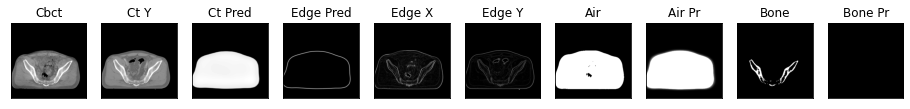

107it [00:49,  1.70it/s]

ssim score = 0.7820336222648621
psnr score = 19.33170509338379
snr score = 9.862068176269531
mae error = 0.044628169387578964
air dice score = 0.9825647965025653
bone dice score = 2.7639579877621902e-11
contour dice score = 0.04377104341983795


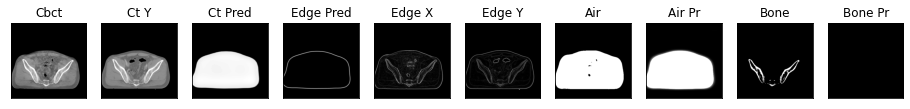

108it [00:49,  1.86it/s]

ssim score = 0.7804086208343506
psnr score = 19.29920768737793
snr score = 9.768310546875
mae error = 0.04487651586532593
air dice score = 0.9809481224300298
bone dice score = 2.894356005704939e-11
contour dice score = 0.007959067821502686


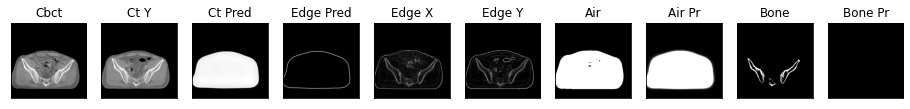

109it [00:50,  1.97it/s]

ssim score = 0.786907434463501
psnr score = 18.7006778717041
snr score = 10.39798641204834
mae error = 0.05519865080714226
air dice score = 0.9873983091402212
bone dice score = 6.325110689036994e-11
contour dice score = 0.14056040346622467


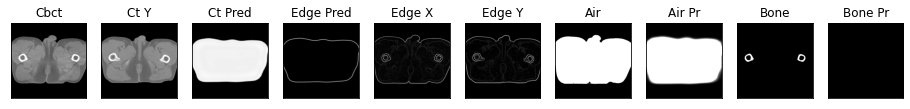

110it [00:50,  2.05it/s]

ssim score = 0.7803583741188049
psnr score = 18.71122169494629
snr score = 10.512819290161133
mae error = 0.055258531123399734
air dice score = 0.988295541969856
bone dice score = 5.681818181495351e-11
contour dice score = 0.1463414579629898


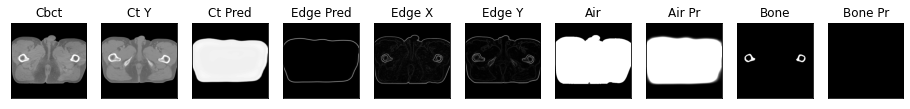

111it [00:51,  2.14it/s]

ssim score = 0.7717779874801636
psnr score = 18.60162353515625
snr score = 10.531176567077637
mae error = 0.056219592690467834
air dice score = 0.9896661367249663
bone dice score = 4.559963520083905e-11
contour dice score = 0.16628175973892212


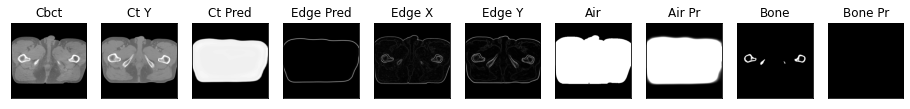

112it [00:51,  1.83it/s]

ssim score = 0.7664688229560852
psnr score = 18.63020133972168
snr score = 10.592045783996582
mae error = 0.056426484137773514
air dice score = 0.9907159331826814
bone dice score = 3.344481605239315e-11
contour dice score = 0.17862100899219513


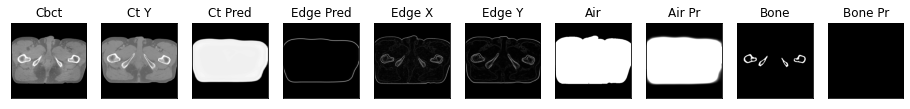

113it [00:52,  1.93it/s]

ssim score = 0.7596377730369568
psnr score = 18.479711532592773
snr score = 10.471793174743652
mae error = 0.05802442133426666
air dice score = 0.991561401980433
bone dice score = 3.231017770493343e-11
contour dice score = 0.17371110618114471


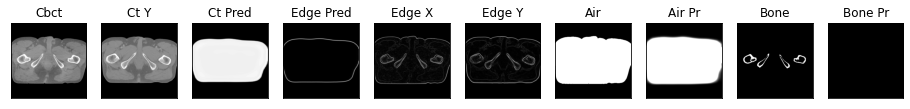

114it [00:52,  2.02it/s]

ssim score = 0.7503274083137512
psnr score = 18.246559143066406
snr score = 10.27305793762207
mae error = 0.06002270430326462
air dice score = 0.9920539313348514
bone dice score = 3.0684258974204225e-11
contour dice score = 0.16705337166786194


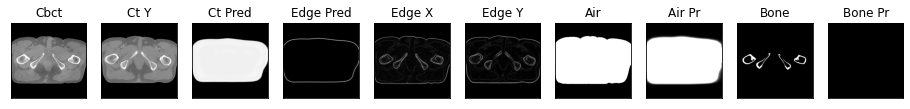

115it [00:53,  2.05it/s]

ssim score = 0.748759925365448
psnr score = 18.127944946289062
snr score = 10.174752235412598
mae error = 0.060558632016181946
air dice score = 0.9921726399760268
bone dice score = 2.6874496102475827e-11
contour dice score = 0.19122402369976044


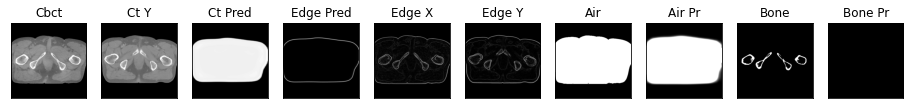

116it [00:53,  2.12it/s]

ssim score = 0.7446679472923279
psnr score = 18.01567268371582
snr score = 10.101555824279785
mae error = 0.061128657311201096
air dice score = 0.9929808411483845
bone dice score = 2.6659557450635575e-11
contour dice score = 0.19034482538700104


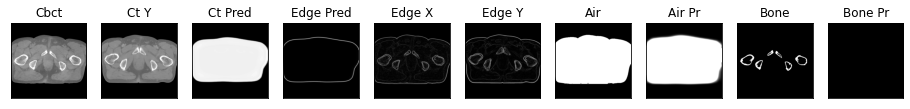

117it [00:54,  2.14it/s]

ssim score = 0.7420844435691833
psnr score = 17.980388641357422
snr score = 10.114951133728027
mae error = 0.06133635714650154
air dice score = 0.9922043876190083
bone dice score = 2.57731958756244e-11
contour dice score = 0.18246550858020782


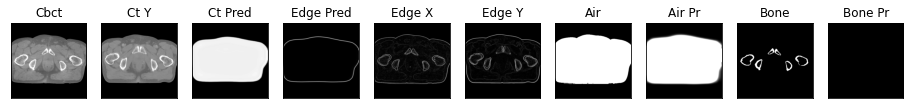

118it [00:54,  2.17it/s]

ssim score = 0.7350499033927917
psnr score = 18.024503707885742
snr score = 10.18167495727539
mae error = 0.06126626208424568
air dice score = 0.991686378981701
bone dice score = 2.4801587300972182e-11
contour dice score = 0.17065738141536713


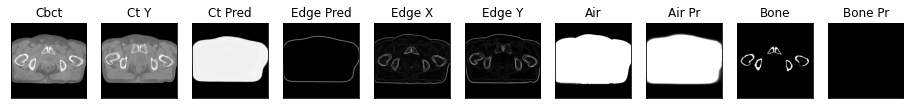

119it [00:55,  2.20it/s]

ssim score = 0.7237709164619446
psnr score = 17.976890563964844
snr score = 10.176841735839844
mae error = 0.06258536875247955
air dice score = 0.9920704542718108
bone dice score = 2.3110700253683597e-11
contour dice score = 0.14129960536956787


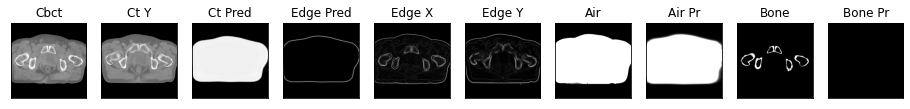

120it [00:55,  2.24it/s]

ssim score = 0.7231407165527344
psnr score = 17.79972267150879
snr score = 10.058012008666992
mae error = 0.06496117264032364
air dice score = 0.9933248150715973
bone dice score = 2.1083702297679026e-11
contour dice score = 0.16876456141471863


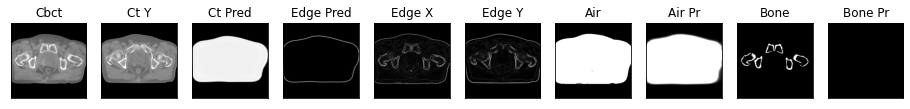

121it [00:55,  2.27it/s]

ssim score = 0.7261759638786316
psnr score = 17.869741439819336
snr score = 10.052657127380371
mae error = 0.06420259922742844
air dice score = 0.9937376929065384
bone dice score = 1.9051247856371665e-11
contour dice score = 0.17228464782238007


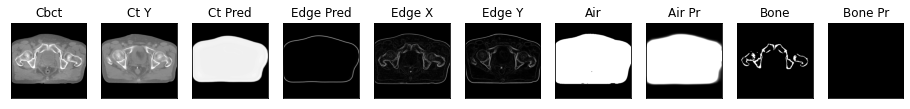

122it [00:56,  1.91it/s]

ssim score = 0.7288250923156738
psnr score = 17.906936645507812
snr score = 9.982635498046875
mae error = 0.06387747824192047
air dice score = 0.9931597415011973
bone dice score = 1.8545994064937944e-11
contour dice score = 0.1672932356595993


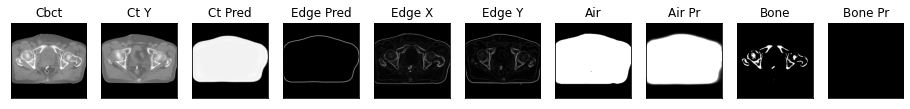

123it [00:57,  1.99it/s]

ssim score = 0.7338903546333313
psnr score = 17.926273345947266
snr score = 9.878885269165039
mae error = 0.06400822848081589
air dice score = 0.9937692201771734
bone dice score = 1.9391118867182643e-11
contour dice score = 0.1252354085445404


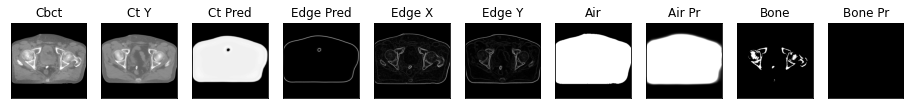

124it [00:57,  2.07it/s]

ssim score = 0.7482630610466003
psnr score = 18.185314178466797
snr score = 10.025496482849121
mae error = 0.06273435056209564
air dice score = 0.992556144335104
bone dice score = 2.0395676116247285e-11
contour dice score = 0.15413711965084076


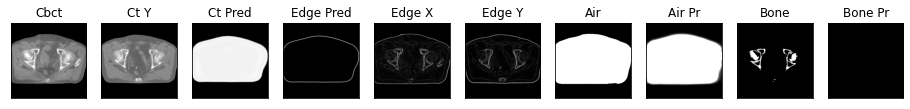

125it [00:58,  2.11it/s]

ssim score = 0.7542873620986938
psnr score = 18.303115844726562
snr score = 10.092650413513184
mae error = 0.06223510950803757
air dice score = 0.992632946017083
bone dice score = 2.0104543626455478e-11
contour dice score = 0.1650071144104004


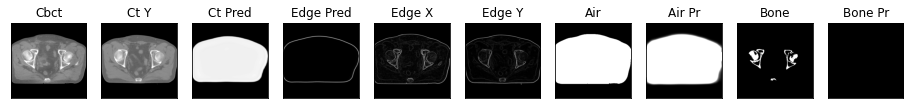

126it [00:58,  2.16it/s]

ssim score = 0.7560949921607971
psnr score = 18.345739364624023
snr score = 10.167428970336914
mae error = 0.06166733801364899
air dice score = 0.9926782584632456
bone dice score = 2.1263023601504083e-11
contour dice score = 0.16357584297657013


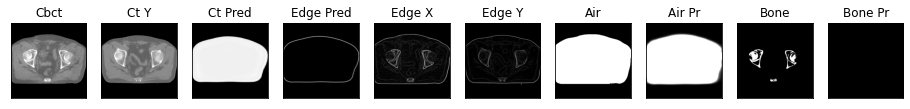

127it [00:58,  2.20it/s]

ssim score = 0.7536717057228088
psnr score = 18.265764236450195
snr score = 10.100932121276855
mae error = 0.06125262752175331
air dice score = 0.9927909252514532
bone dice score = 2.2983222247230908e-11
contour dice score = 0.13479924201965332


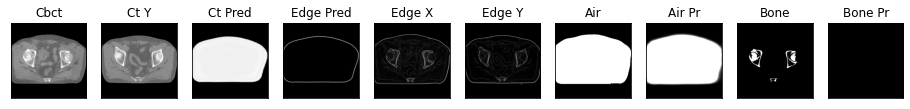

128it [00:59,  2.20it/s]

ssim score = 0.7571761012077332
psnr score = 18.61994171142578
snr score = 10.313616752624512
mae error = 0.05899551883339882
air dice score = 0.9932570922811796
bone dice score = 2.2810218977581884e-11
contour dice score = 0.13660413026809692


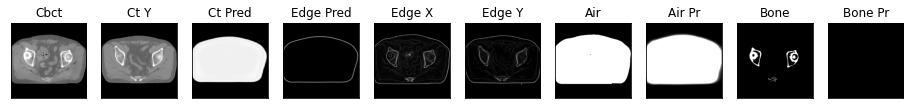

129it [00:59,  2.23it/s]

ssim score = 0.760266900062561
psnr score = 18.630407333374023
snr score = 10.26477336883545
mae error = 0.05844492465257645
air dice score = 0.9941933707160763
bone dice score = 2.6745119015064317e-11
contour dice score = 0.12530121207237244


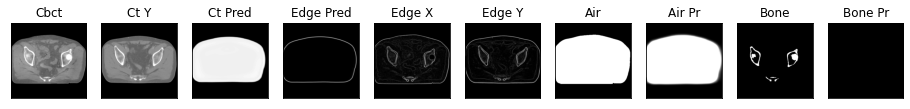

130it [01:00,  2.24it/s]

ssim score = 0.7577124834060669
psnr score = 18.579631805419922
snr score = 10.239645004272461
mae error = 0.05719970539212227
air dice score = 0.9944995927810139
bone dice score = 3.707823507463559e-11
contour dice score = 0.12747465074062347


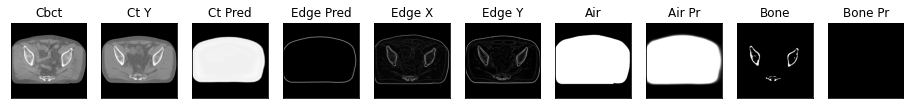

131it [01:00,  2.25it/s]

ssim score = 0.7591447234153748
psnr score = 18.656824111938477
snr score = 10.38965129852295
mae error = 0.056188277900218964
air dice score = 0.9943569732533593
bone dice score = 3.449465332754417e-11
contour dice score = 0.1266312301158905


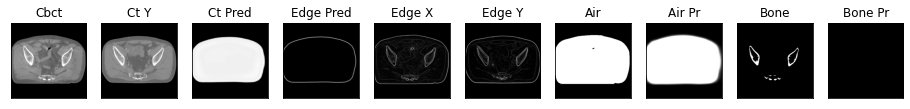

132it [01:01,  1.92it/s]

ssim score = 0.7518942356109619
psnr score = 18.522798538208008
snr score = 10.384855270385742
mae error = 0.0576418898999691
air dice score = 0.9941642475217459
bone dice score = 3.211303789235347e-11
contour dice score = 0.11489775776863098


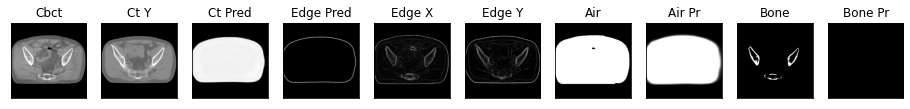

133it [01:01,  2.01it/s]

ssim score = 0.7430554628372192
psnr score = 18.540103912353516
snr score = 10.43612289428711
mae error = 0.057558026164770126
air dice score = 0.992879808528638
bone dice score = 2.913752913668014e-11
contour dice score = 0.09995100647211075


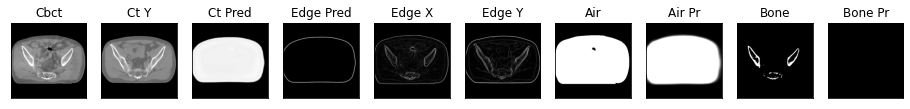

134it [01:02,  2.07it/s]

ssim score = 0.7452853918075562
psnr score = 18.865110397338867
snr score = 10.73133659362793
mae error = 0.05564179643988609
air dice score = 0.9940506952874331
bone dice score = 2.358490565982111e-11
contour dice score = 0.09131075441837311


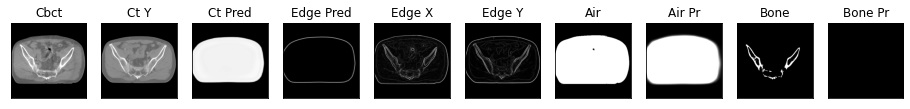

135it [01:02,  2.12it/s]

ssim score = 0.7497383952140808
psnr score = 19.147048950195312
snr score = 10.949901580810547
mae error = 0.053550779819488525
air dice score = 0.993360630529043
bone dice score = 2.581311306076889e-11
contour dice score = 0.08956693112850189


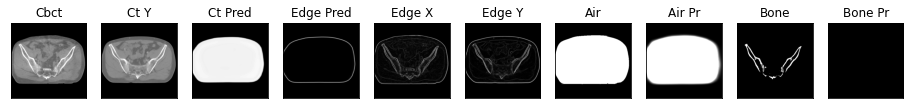

136it [01:03,  2.18it/s]

ssim score = 0.7620530724525452
psnr score = 18.628591537475586
snr score = 10.105982780456543
mae error = 0.049598682671785355
air dice score = 0.9871341890663066
bone dice score = 2.3546032492970425e-11
contour dice score = 0.034640856087207794


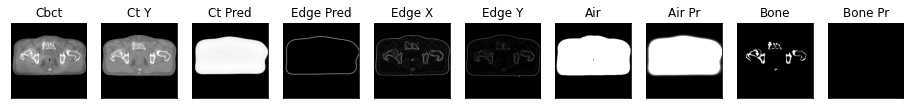

137it [01:03,  2.21it/s]

ssim score = 0.7564751505851746
psnr score = 18.533733367919922
snr score = 10.051137924194336
mae error = 0.05035177990794182
air dice score = 0.9865509112000999
bone dice score = 2.4479804160967446e-11
contour dice score = 0.06342711299657822


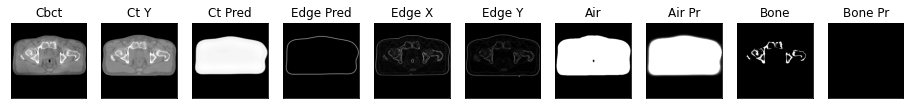

138it [01:03,  2.25it/s]

ssim score = 0.7557955384254456
psnr score = 18.562252044677734
snr score = 10.087443351745605
mae error = 0.05027235299348831
air dice score = 0.9869909671998417
bone dice score = 2.5484199795476957e-11
contour dice score = 0.058521561324596405


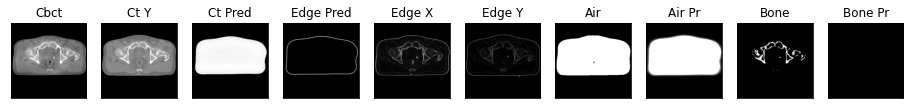

139it [01:04,  2.26it/s]

ssim score = 0.7619761824607849
psnr score = 18.65581703186035
snr score = 10.122587203979492
mae error = 0.04925169423222542
air dice score = 0.9863440399070144
bone dice score = 2.427184465960505e-11
contour dice score = 0.05758354812860489


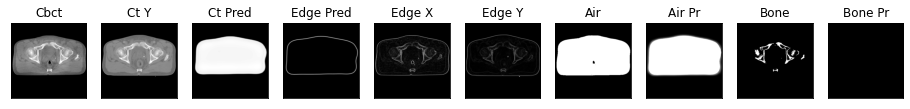

140it [01:04,  2.32it/s]

ssim score = 0.7726083397865295
psnr score = 18.928945541381836
snr score = 10.240091323852539
mae error = 0.045934636145830154
air dice score = 0.9878018459220284
bone dice score = 2.960331557046764e-11
contour dice score = 0.04233350604772568


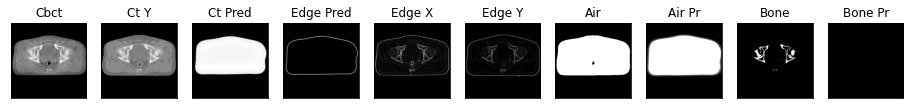

141it [01:05,  2.31it/s]

ssim score = 0.774783730506897
psnr score = 18.87143325805664
snr score = 10.161775588989258
mae error = 0.045873090624809265
air dice score = 0.9868816017299751
bone dice score = 2.7601435273872442e-11
contour dice score = 0.04557224363088608


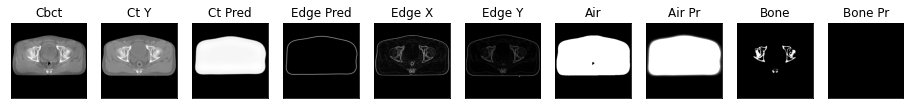

142it [01:05,  1.98it/s]

ssim score = 0.7798904776573181
psnr score = 18.840070724487305
snr score = 10.11478328704834
mae error = 0.046045370399951935
air dice score = 0.9865243434888008
bone dice score = 2.7352297592249663e-11
contour dice score = 0.03846153989434242


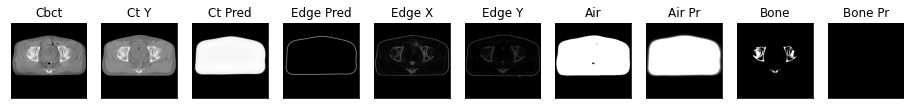

143it [01:06,  2.10it/s]

ssim score = 0.7811392545700073
psnr score = 18.59122085571289
snr score = 9.875298500061035
mae error = 0.04769071191549301
air dice score = 0.9854665578248011
bone dice score = 2.7210884353001064e-11
contour dice score = 0.027097446843981743


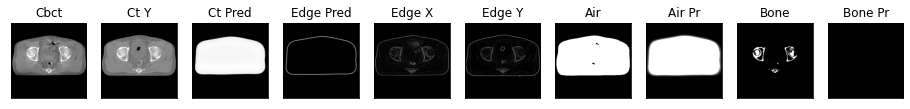

144it [01:06,  2.18it/s]

ssim score = 0.7817478775978088
psnr score = 18.40285301208496
snr score = 9.742711067199707
mae error = 0.048876672983169556
air dice score = 0.985868941509517
bone dice score = 2.6666666665955555e-11
contour dice score = 0.01671891286969185


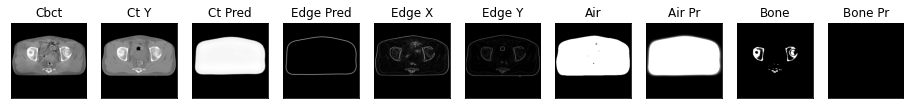

145it [01:07,  2.24it/s]

ssim score = 0.779034435749054
psnr score = 18.22823715209961
snr score = 9.546165466308594
mae error = 0.04982737824320793
air dice score = 0.9845735236470246
bone dice score = 2.7389756230419344e-11
contour dice score = 0.006289307959377766


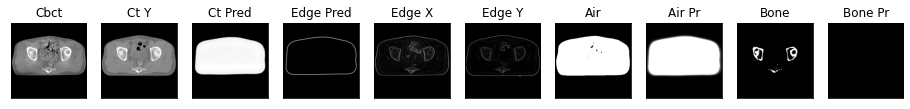

146it [01:07,  2.27it/s]

ssim score = 0.7778964042663574
psnr score = 18.292097091674805
snr score = 9.539252281188965
mae error = 0.04909347742795944
air dice score = 0.9841375006741107
bone dice score = 3.041362530321127e-11
contour dice score = 0.017866525799036026


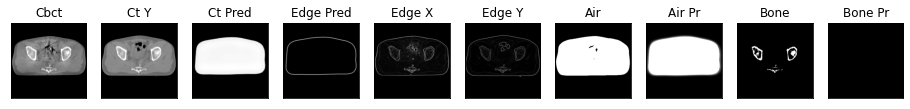

147it [01:08,  2.30it/s]

ssim score = 0.7758033275604248
psnr score = 18.415157318115234
snr score = 9.618416786193848
mae error = 0.048269957304000854
air dice score = 0.9865069084628774
bone dice score = 3.231017770493343e-11
contour dice score = 0.007391763385385275


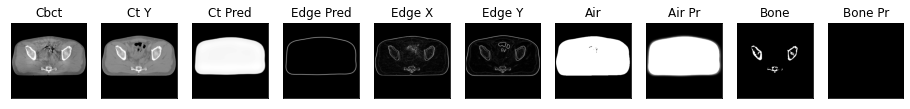

148it [01:08,  2.31it/s]

ssim score = 0.7767598628997803
psnr score = 18.50708770751953
snr score = 9.709251403808594
mae error = 0.0473954938352108
air dice score = 0.985370158219041
bone dice score = 3.127932436561528e-11
contour dice score = 0.007419183850288391


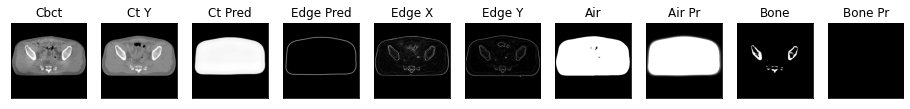

149it [01:08,  2.33it/s]

ssim score = 0.7737239003181458
psnr score = 18.541748046875
snr score = 9.757268905639648
mae error = 0.04769256338477135
air dice score = 0.9837151789463987
bone dice score = 2.999400119886041e-11
contour dice score = 5.310674469627408e-11


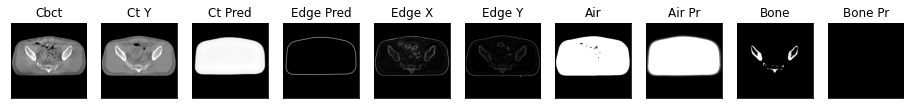

150it [01:09,  2.36it/s]

ssim score = 0.76700359582901
psnr score = 18.41310691833496
snr score = 9.683831214904785
mae error = 0.04864788427948952
air dice score = 0.9813854706727612
bone dice score = 2.501250625250094e-11
contour dice score = 0.004262120462954044


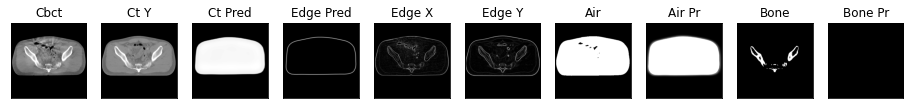

151it [01:09,  2.36it/s]

ssim score = 0.762360692024231
psnr score = 18.211585998535156
snr score = 9.50168228149414
mae error = 0.05043776333332062
air dice score = 0.9803184154444181
bone dice score = 2.5595085742882133e-11
contour dice score = 0.0032085562124848366


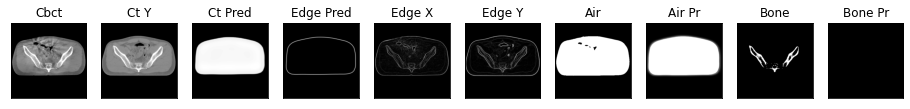

152it [01:10,  1.94it/s]

ssim score = 0.7601168751716614
psnr score = 18.092472076416016
snr score = 9.327829360961914
mae error = 0.051796600222587585
air dice score = 0.9797901313052987
bone dice score = 2.8042624788893925e-11
contour dice score = 0.00644468329846859


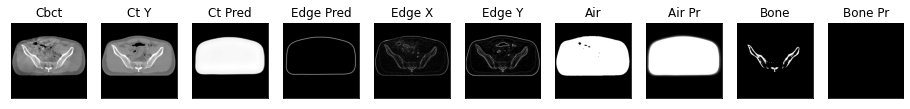

153it [01:10,  2.06it/s]

ssim score = 0.7565414905548096
psnr score = 18.037355422973633
snr score = 9.236358642578125
mae error = 0.0524289608001709
air dice score = 0.981637841740182
bone dice score = 2.801120448100809e-11
contour dice score = 0.004314994439482689


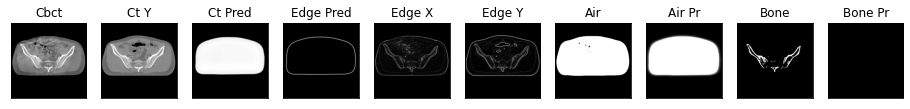

154it [01:11,  2.13it/s]

ssim score = 0.7556498646736145
psnr score = 18.003244400024414
snr score = 9.202320098876953
mae error = 0.05289175733923912
air dice score = 0.9823867382499902
bone dice score = 2.5252525251887564e-11
contour dice score = 0.016242556273937225


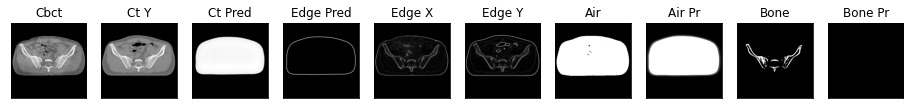

155it [01:11,  2.17it/s]

ssim score = 0.7535555958747864
psnr score = 18.12502098083496
snr score = 9.322675704956055
mae error = 0.0528012290596962
air dice score = 0.9813100299165632
bone dice score = 2.552322613513213e-11
contour dice score = 0.007625272497534752


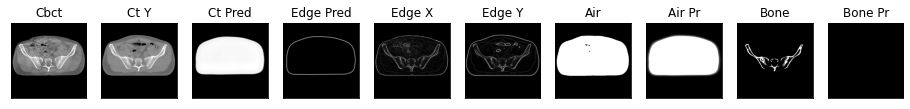

156it [01:12,  2.21it/s]

ssim score = 0.7505451440811157
psnr score = 18.06197166442871
snr score = 9.264664649963379
mae error = 0.05309814214706421
air dice score = 0.9794455670624057
bone dice score = 2.570033410368285e-11
contour dice score = 0.005464480724185705


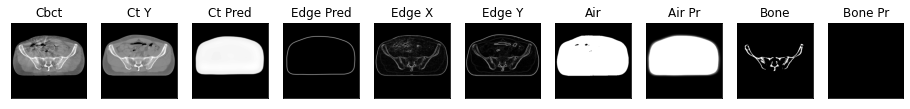

157it [01:12,  2.25it/s]

ssim score = 0.7512006163597107
psnr score = 18.07353973388672
snr score = 9.258960723876953
mae error = 0.053323693573474884
air dice score = 0.9775434763680293
bone dice score = 2.5753283542988583e-11
contour dice score = 0.02086765505373478


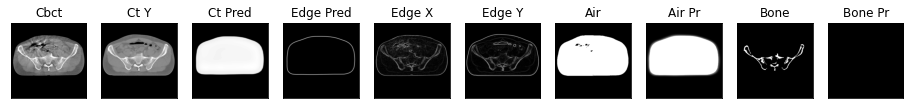

158it [01:12,  2.30it/s]

ssim score = 0.7468036413192749
psnr score = 17.821035385131836
snr score = 8.987832069396973
mae error = 0.055649373680353165
air dice score = 0.9751445592434599
bone dice score = 2.3992322456238187e-11
contour dice score = 0.028713418170809746


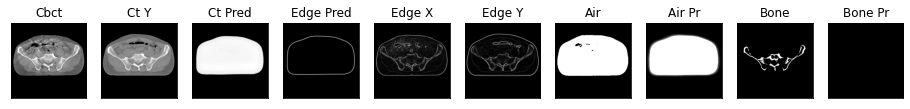

159it [01:13,  2.32it/s]

ssim score = 0.7423573136329651
psnr score = 17.756282806396484
snr score = 8.877140045166016
mae error = 0.056477852165699005
air dice score = 0.9754744059958735
bone dice score = 2.3137436371514637e-11
contour dice score = 0.023346303030848503


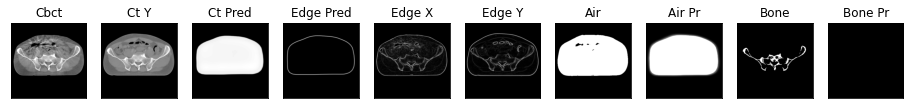

160it [01:13,  2.34it/s]

ssim score = 0.745235025882721
psnr score = 17.937456130981445
snr score = 9.004517555236816
mae error = 0.05547891557216644
air dice score = 0.9772358633033349
bone dice score = 2.277385561323676e-11
contour dice score = 0.010067113675177097


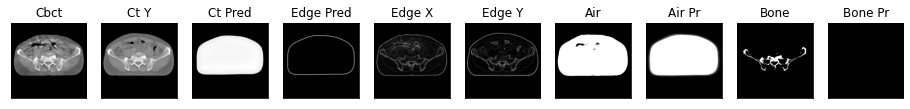

161it [01:14,  2.30it/s]

ssim score = 0.7421156764030457
psnr score = 17.747028350830078
snr score = 8.844552040100098
mae error = 0.05702366307377815
air dice score = 0.9764165685025551
bone dice score = 2.228660574944759e-11
contour dice score = 0.02812148444354534


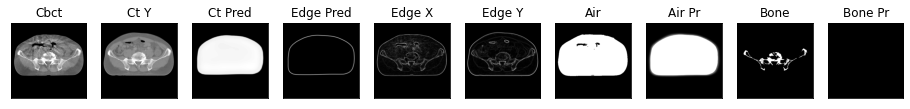

162it [01:14,  1.95it/s]

ssim score = 0.7419778108596802
psnr score = 17.64458656311035
snr score = 8.686885833740234
mae error = 0.05757962539792061
air dice score = 0.9762318002121491
bone dice score = 2.3148148147612312e-11
contour dice score = 0.047164514660835266


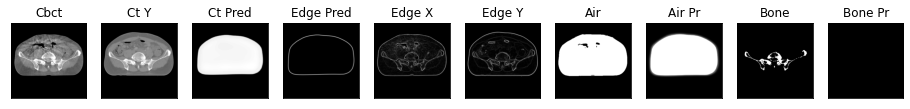

163it [01:15,  2.08it/s]

ssim score = 0.7510172724723816
psnr score = 17.998584747314453
snr score = 8.893351554870605
mae error = 0.05485241860151291
air dice score = 0.9778013876145122
bone dice score = 2.4425989251968098e-11
contour dice score = 0.01692047342658043


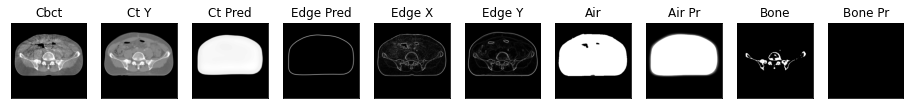

164it [01:15,  2.21it/s]

ssim score = 0.7920163869857788
psnr score = 19.93569564819336
snr score = 10.316609382629395
mae error = 0.04708971455693245
air dice score = 0.9864183619002532
bone dice score = 5.515719801129855e-11
contour dice score = 0.003923492040485144


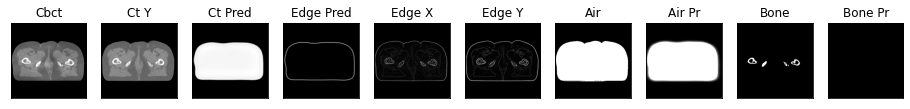

165it [01:16,  2.30it/s]

ssim score = 0.7867704033851624
psnr score = 19.785884857177734
snr score = 10.287810325622559
mae error = 0.04783960059285164
air dice score = 0.9862250038611275
bone dice score = 4.6554934820923885e-11
contour dice score = 0.007003501523286104


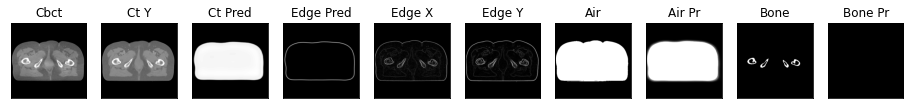

166it [01:16,  2.36it/s]

ssim score = 0.7809844613075256
psnr score = 19.749359130859375
snr score = 10.33420181274414
mae error = 0.04805035889148712
air dice score = 0.9860622848497796
bone dice score = 4.1666666664930555e-11
contour dice score = 0.008893280290067196


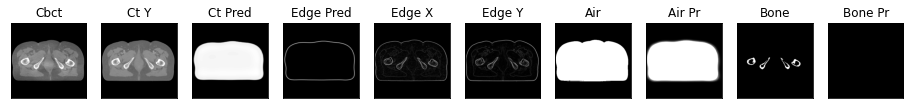

167it [01:16,  2.43it/s]

ssim score = 0.7766559720039368
psnr score = 19.623437881469727
snr score = 10.27172565460205
mae error = 0.04893476516008377
air dice score = 0.9859136473825694
bone dice score = 3.703703703566529e-11
contour dice score = 0.008897677063941956


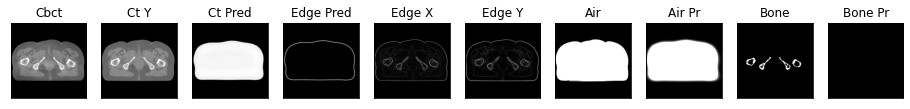

168it [01:17,  2.49it/s]

ssim score = 0.7746087908744812
psnr score = 19.50220489501953
snr score = 10.178953170776367
mae error = 0.04978230968117714
air dice score = 0.9860949837436237
bone dice score = 3.527336860545773e-11
contour dice score = 0.01095617562532425


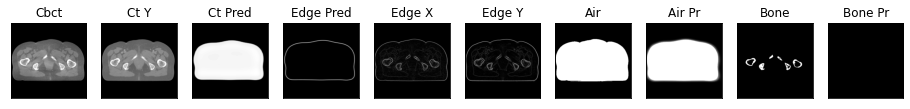

169it [01:17,  2.53it/s]

ssim score = 0.7758633494377136
psnr score = 19.47472381591797
snr score = 10.174427032470703
mae error = 0.049933116883039474
air dice score = 0.9861679809014062
bone dice score = 3.688675765264158e-11
contour dice score = 0.01673228293657303


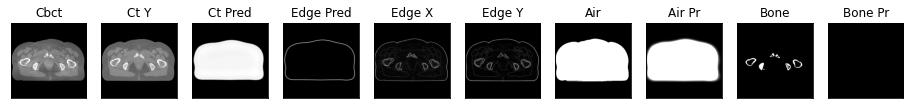

170it [01:18,  2.57it/s]

ssim score = 0.772446870803833
psnr score = 19.49524688720703
snr score = 10.226278305053711
mae error = 0.04982299730181694
air dice score = 0.9861284435435688
bone dice score = 3.631082062322764e-11
contour dice score = 0.021494871005415916


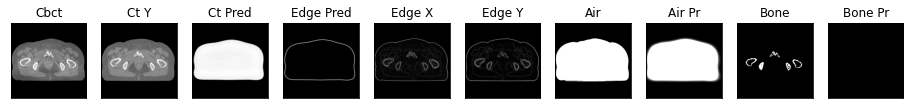

171it [01:18,  2.53it/s]

ssim score = 0.7687907218933105
psnr score = 19.4583683013916
snr score = 10.237762451171875
mae error = 0.0500301867723465
air dice score = 0.9861386138613961
bone dice score = 3.547357218746103e-11
contour dice score = 0.012333965860307217


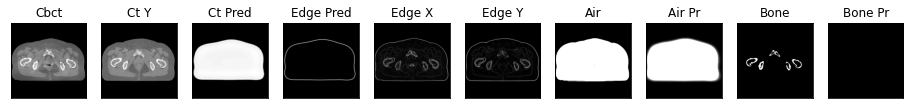

172it [01:19,  1.84it/s]

ssim score = 0.7664013504981995
psnr score = 19.409040451049805
snr score = 10.231179237365723
mae error = 0.050200846046209335
air dice score = 0.9851126262190493
bone dice score = 3.3090668430407324e-11
contour dice score = 0.017467249184846878


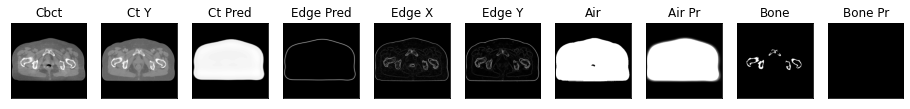

173it [01:19,  1.85it/s]

ssim score = 0.7604858875274658
psnr score = 19.308181762695312
snr score = 10.21802043914795
mae error = 0.05112288519740105
air dice score = 0.9850216593271708
bone dice score = 2.8352707682779906e-11
contour dice score = 0.01603773608803749


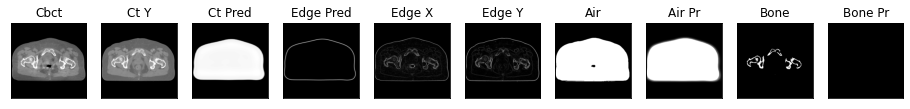

174it [01:20,  1.92it/s]

ssim score = 0.7613977789878845
psnr score = 19.240680694580078
snr score = 10.2637939453125
mae error = 0.0515427440404892
air dice score = 0.9862349567741988
bone dice score = 2.341372043962974e-11
contour dice score = 0.05490925908088684


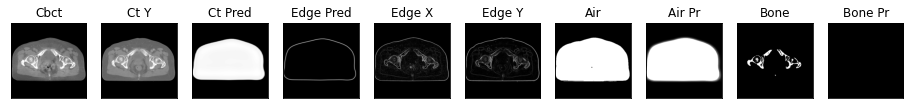

175it [01:20,  2.00it/s]

ssim score = 0.766137957572937
psnr score = 19.612632751464844
snr score = 10.507192611694336
mae error = 0.048856597393751144
air dice score = 0.9841015440534737
bone dice score = 3.394433129552124e-11
contour dice score = 0.035431236028671265


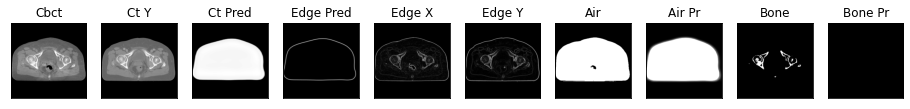

176it [01:21,  2.08it/s]

ssim score = 0.7724757790565491
psnr score = 19.858501434326172
snr score = 10.643640518188477
mae error = 0.04728876054286957
air dice score = 0.983788182720256
bone dice score = 3.8654812522665065e-11
contour dice score = 0.0471031554043293


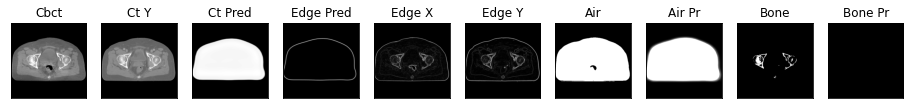

177it [01:21,  2.13it/s]

ssim score = 0.777225136756897
psnr score = 19.77869415283203
snr score = 10.536705017089844
mae error = 0.04843272641301155
air dice score = 0.984266753915541
bone dice score = 3.427004797689273e-11
contour dice score = 0.04528650641441345


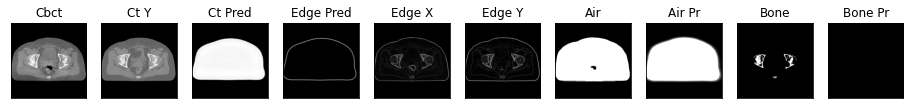

178it [01:22,  2.23it/s]

ssim score = 0.780522882938385
psnr score = 19.62482261657715
snr score = 10.37483024597168
mae error = 0.05006398260593414
air dice score = 0.9863514725299651
bone dice score = 3.3222591361022506e-11
contour dice score = 0.05550329387187958


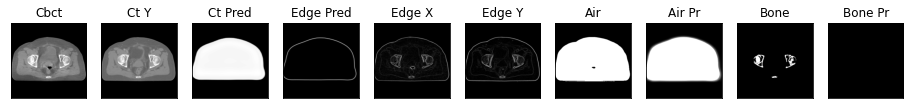

179it [01:22,  2.32it/s]

ssim score = 0.7824849486351013
psnr score = 19.521671295166016
snr score = 10.305908203125
mae error = 0.05106455832719803
air dice score = 0.987344604326616
bone dice score = 3.164556961925172e-11
contour dice score = 0.07488151639699936


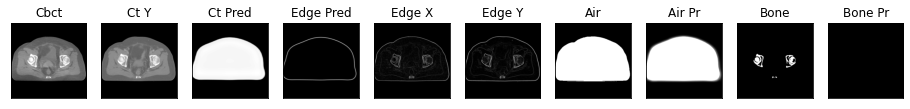

180it [01:22,  2.34it/s]

ssim score = 0.7786648273468018
psnr score = 19.149063110351562
snr score = 9.984790802001953
mae error = 0.05303622782230377
air dice score = 0.9872329211714456
bone dice score = 3.162555344618515e-11
contour dice score = 0.10174418240785599


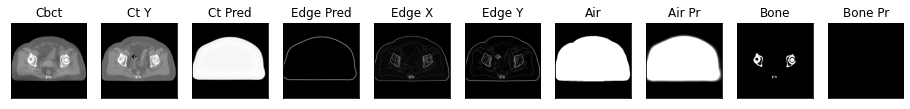

181it [01:23,  2.38it/s]

ssim score = 0.7653238773345947
psnr score = 18.8753719329834
snr score = 9.748659133911133
mae error = 0.054396919906139374
air dice score = 0.9873020677131428
bone dice score = 3.448275861950059e-11
contour dice score = 0.09361287206411362


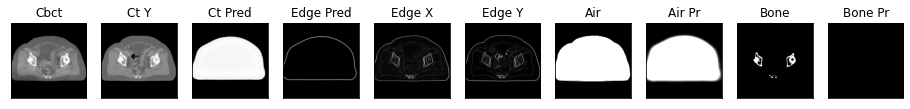

182it [01:23,  2.10it/s]

ssim score = 0.7567576169967651
psnr score = 18.817401885986328
snr score = 9.618250846862793
mae error = 0.055547792464494705
air dice score = 0.9874439339613724
bone dice score = 4.456327985541162e-11
contour dice score = 0.10271605104207993


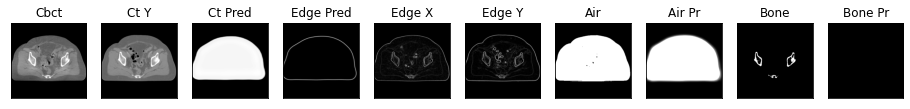

183it [01:24,  2.08it/s]

ssim score = 0.7581413388252258
psnr score = 18.84157943725586
snr score = 9.624435424804688
mae error = 0.05574749782681465
air dice score = 0.9856806431529751
bone dice score = 4.468275245555484e-11
contour dice score = 0.09590409696102142


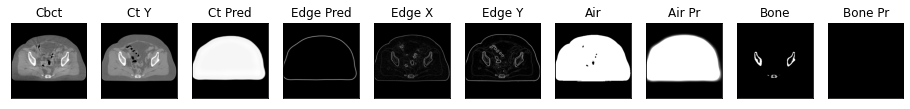

184it [01:25,  1.69it/s]

ssim score = 0.7605226039886475
psnr score = 18.898338317871094
snr score = 9.746110916137695
mae error = 0.05554475262761116
air dice score = 0.9864606850719262
bone dice score = 4.2863266179045725e-11
contour dice score = 0.07500000298023224


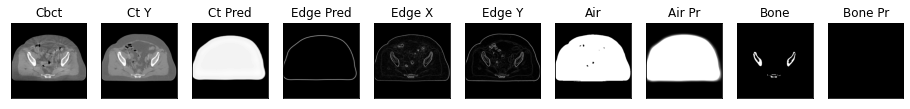

185it [01:25,  1.63it/s]

ssim score = 0.7529488801956177
psnr score = 18.58411407470703
snr score = 9.486977577209473
mae error = 0.05823522061109543
air dice score = 0.9883346501391023
bone dice score = 3.6656891494257445e-11
contour dice score = 0.06464646756649017


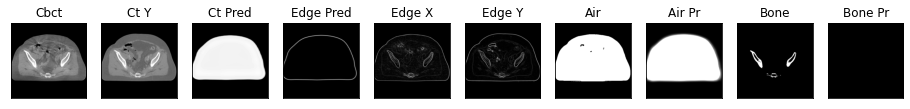

186it [01:26,  1.65it/s]

ssim score = 0.7463757395744324
psnr score = 18.335153579711914
snr score = 9.302449226379395
mae error = 0.060415301471948624
air dice score = 0.989152957118338
bone dice score = 3.059975520102204e-11
contour dice score = 0.06669984757900238


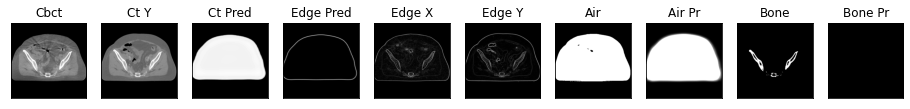

187it [01:27,  1.70it/s]

ssim score = 0.7420248985290527
psnr score = 18.308452606201172
snr score = 9.348608016967773
mae error = 0.061087802052497864
air dice score = 0.9885132446659393
bone dice score = 2.839295854547436e-11
contour dice score = 0.06889665871858597


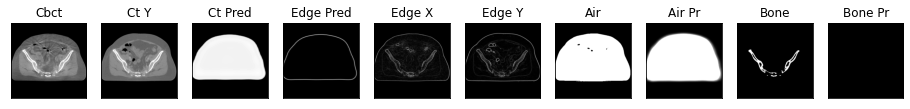

188it [01:27,  1.87it/s]

ssim score = 0.7370613813400269
psnr score = 18.335872650146484
snr score = 9.371737480163574
mae error = 0.061612214893102646
air dice score = 0.9873404606647798
bone dice score = 2.908667830049195e-11
contour dice score = 0.07224146276712418


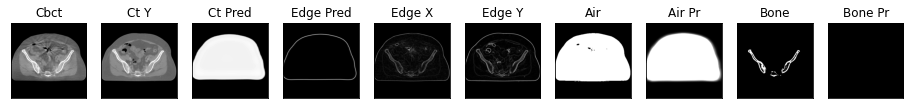

189it [01:27,  2.01it/s]

ssim score = 0.7342818975448608
psnr score = 18.28888702392578
snr score = 9.302574157714844
mae error = 0.06253184378147125
air dice score = 0.9882262408618775
bone dice score = 2.8145229382827323e-11
contour dice score = 0.07575011998414993


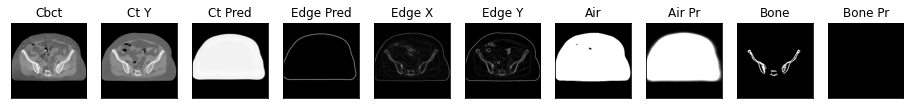

190it [01:28,  2.12it/s]

ssim score = 0.7346265316009521
psnr score = 18.39979362487793
snr score = 9.425115585327148
mae error = 0.0623166449368
air dice score = 0.9895158980234956
bone dice score = 2.935995302321315e-11
contour dice score = 0.07034684717655182


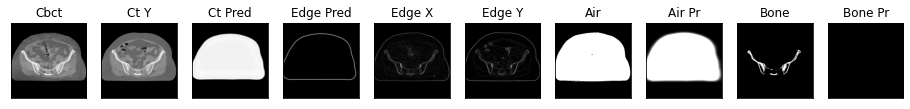

191it [01:28,  2.15it/s]


In [42]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [43]:
discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(discriminator)

In [44]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [45]:
# score_ssim, score_psnr, score_snr, score_mae, score_air, score_bone, score_cont, score_acc
# unmasked
eval_epoch(model, discriminator, testloader, device)

191it [00:13, 14.46it/s]


(0.782142412912159,
 19.244704321416886,
 10.248976442826356,
 0.0479720472333787,
 0.9857565711509845,
 2.9564617685948747e-11,
 0.09865364996519886,
 0.5)

In [46]:
# import torchvision.models as models
# models.vgg16(pretrained=True)